## SAF policy container ver.

In [ ]:
using Pkg
using JuMP, Ipopt, PATHSolver, Complementarity, LinearAlgebra, Printf
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("StatsPlots")
import Pkg; Pkg.add("DataStructures")

In [ ]:
# Policy parameters
t = 190                      # Carbon Tax ($/ton CO2)
theta_avi =  0.02             # RFS blending ratio
sigma =  0.97            # LCFS CI limit
p = 3    # Tax Credit per ton

3

A container for the common parameters

In [382]:
params = Dict(
    # Meta
    :meta => Dict(
        :process => ["Jet fuel", "Conventional ATJ-SAF", "Climate-smart ATJ-SAF",
                     "Conventional HEFA-SAF", "Climate-smart HEFA-SAF", "Non soy HEFA-SAF",
                     "Gasoline", "Ethanol",
                     "Diesel", "Soy Biodiesel", "Non soy Biodiesel",
                     "Soy Renewable Diesel", "Non soy Renewable diesel",
                     "Food: Corn", "Food: Soy oil"],
        :scenario => ["Status quo", "Carbon tax", "RFS", "LCFS", "Tax credit", "2024 observed"]
    ),

    # Coefficients
    :coeff => Dict(
        :delta => [0.01155398, 0.006545966, 0.005282266, 0.004869036, 0.004237186, 0.002486962,         # CI
                   0.012051015, 0.003570138, 0.013507512, 0.002547826, 0.002680263,
                   0.003202355, 0.002521693, 0.006295, 0.00783],
        :alpha => [0, 0.003305612, 0.003636174, 0.014762163, 0.016238379, 0,                            # land use
                   0, 0.001917255, 0, 0.013931791, 0, 0.014762163, 0,
                   0.00556004, 0.00184527],
        :r => [58.95847369, 21.10983193, 7.256737051],                                                  # conversion rates (jet fuel, gasoline, diesel)
        :beta => [0.973424742, 0.681920857, 0.937978731, 0.964155574],                                  # SAF to jet, ethanol to gasoline conversion (SAF, ethanol, biodiesel, renewable diesel)
        :theta => 0.125                                                                                 # RFS D6 constraint
    ),

    # Demand parameters
    # Isoelastic demand function and the price of substitute goods
    # p(q) = p0*(q/q0)^(1/sigma) = A*q^k where sigma < 0
    # s = q0*(p_sub/p0)^(-1/sigma)
    :demand => Dict(
        :avi => Dict(:k => -1/0.4,  :A => 0.04 * 1199.13^(1/0.4),  :s => 1199.13 * (10/0.04)^(-0.4)),
        :gas => Dict(:k => -1/0.2,  :A => 0.127 * 2899.258^(1/0.2), :s => 2899.258 * (10/0.1279)^(1/0.2)),
        :die => Dict(:k => -1/0.1,  :A => 0.3356 * 357.28^(1/0.1),  :s => 357.28 * (10/0.3356)^(1/0.1)),
        :corn => Dict(:k => -1/0.23, :A => 4.55 * 7.2^(1/0.23),     :s => 7.2 * (20/4.55)^(1/0.23)),
        :soy  => Dict(:k => -1/0.18, :A => 0.475 * 14.164^(1/0.18), :s => 14.164 * (5/0.475)^(1/0.18))
    ),

    # Supply parameters
    # Hockey stick marginal cost= c0 + c1*q + c2*(x-v)^2 for fuel
    # isoelastic marginal cost = (x/a)^b for food
    :supply => Dict(
        :c0 => [0.0575*20.3386, 2.839, 2.839*1.5, 2.796, 2.796*1.5, 2.796,
                1.35, 0, 0.0277*43.9, 2.238, 2.238, 2.823, 2.823],
        :c1 => [0.0575, 45.06, 45.06*1.5, 17.601, 17.601*1.5, 6.510,
                0.011, 0.129, 0.0277, 0.999, 1.324, 1.391, 0.515],
        :c2 => [50, 5, 5, 5, 5, 10,
                50, 50, 50, 10, 50, 10, 50],
        :v  => [24050, 6.9, 6.9, 2.7, 2.7, 2.092,
                42557, 18.01, 64.68, 2.092, 3, 4.328, 5],
        :a  => [4.8524, 16.7],
        :b  => [3.8462, 5.291]
    )
)


Dict{Symbol, Dict{Symbol}} with 4 entries:
  :coeff  => Dict{Symbol, Any}(:alpha=>[0.0, 0.00330561, 0.00363617, 0.0147622,…
  :meta   => Dict(:process=>["Jet fuel", "Conventional ATJ-SAF", "Climate-smart…
  :demand => Dict(:die=>Dict(:A=>1.13739e25, :k=>-10.0, :s=>1.97147e17), :gas=>…
  :supply => Dict{Symbol, Vector}(:a=>[4.8524, 16.7], :b=>[3.8462, 5.291], :v=>…

Base model

In [383]:
function base_model(params)
    model = Model(Ipopt.Optimizer)
    set_silent(model)

    @variable(model, x[1:15]>=0)
    set_name.(x, params[:meta][:process])

    coeff = params[:coeff]
    demand = params[:demand]
    supply = params[:supply]
    r = coeff[:r]
    beta = coeff[:beta]
    theta = coeff[:theta]
    alpha = coeff[:alpha]
    delta = coeff[:delta]
    c0, c1, c2, v = supply[:c0], supply[:c1], supply[:c2], supply[:v]
    a, b = supply[:a], supply[:b]
    A_avi, k_avi, s_avi = demand[:avi][:A], demand[:avi][:k], demand[:avi][:s]
    A_gas, k_gas, s_gas = demand[:gas][:A], demand[:gas][:k], demand[:gas][:s]
    A_die, k_die, s_die = demand[:die][:A], demand[:die][:k], demand[:die][:s]
    A_corn, k_corn, s_corn = demand[:corn][:A], demand[:corn][:k], demand[:corn][:s]
    A_soy,  k_soy,  s_soy  = demand[:soy][:A],  demand[:soy][:k],  demand[:soy][:s]

    @expression(model, u_avi,  r[1] * (x[1] + beta[1] * (x[2] + x[3] + x[4] + x[5] + x[6])))
    @expression(model, u_roadgasoline, r[2] * (x[7] + beta[2] * x[8]))
    @expression(model, u_roaddiesel, r[3] * (x[9] + beta[3] * (x[10] + x[11]) + beta[4] * (x[12] + x[13])))
    @expression(model, u_foodcorn, x[14])
    @expression(model, u_foodsoy, x[15])

    @expression(model, tb_aviation, A_avi  * ( u_avi^(k_avi+1)   - s_avi^(k_avi+1) ) / (k_avi+1) )
    @expression(model, tb_roadgasoline, A_gas * ( u_roadgasoline^(k_gas+1) - s_gas^(k_gas+1) ) / (k_gas+1) )
    @expression(model, tb_roaddiesel, A_die * ( u_roaddiesel^(k_die+1) - s_die^(k_die+1) ) / (k_die+1) )
    @expression(model, tb_foodcorn, A_corn * ( u_foodcorn^(k_corn+1) - s_corn^(k_corn+1) ) / (k_corn+1) )
    @expression(model, tb_foodsoy, A_soy * ( u_foodsoy^(k_soy+1) - s_soy^(k_soy+1) ) / (k_soy+1) )

    @expression(model, tc,
        sum(
            ifelse(
                x[i] <= v[i],
                c0[i]*x[i] + 0.5*c1[i]*x[i]^2,
                (c0[i]*v[i] + 0.5*c1[i]*v[i]^2) +
                c0[i]*(x[i]-v[i]) + 0.5*c1[i]*(x[i]^2 - v[i]^2) + (c2[i]/3)*(x[i]-v[i])^3
            )
            for i in 1:13
        ) +
        x[14]^(b[1]+1)/(a[1]^b[1]*(b[1]+1)) +
        x[15]^(b[2]+1)/(a[2]^b[2]*(b[2]+1))
    )

    @constraint(model, rfs_d6, x[8] + 1.5 * (x[10] + x[11]) +1.7 * (x[12]+x[13]) - theta * x[7] - theta * x[9] >= 0)                        # RFS D6 (ethanol)
    @constraint(model, gasoline_blendwall, 0.9 * x[8] - 0.1 * x[7]<=0)                                                        # ethanol blendwall (10% of gasoline)
    @constraint(model, diesel_blendwall, 0.95 * (x[10] + x[11]) - 0.05 * x[9]<=0)                                                        # biodiesel blendwall (5% of diesel)
    @constraint(model, nonsoy_capacity, 7.55 * x[11] + 8.5 * x[13] + 9 * x[6]<=30)  # non soy feedstock capacity
    
    @objective(model, Max, tb_aviation + tb_roadgasoline + tb_roaddiesel + tb_foodcorn + tb_foodsoy - tc)

    return model
end

base_model (generic function with 1 method)

In [384]:
function model_carbontax(parms, L_corn_base, L_soy_base; t)
    model = base_model(parms)
    x = all_variables(model)
    alpha = parms[:coeff][:alpha]
    theta = parms[:coeff][:theta]
    delta = parms[:coeff][:delta]
    
    @constraint(model, corn_landuse, sum(alpha[i] * x[i] for i in [2, 3, 8, 14]) <= L_corn_base)
    @constraint(model, soy_landuse,  sum(alpha[i] * x[i] for i in [4, 5, 10, 12, 15]) <= L_soy_base)

    @expression(model, ct, sum(t * delta[i] * x[i] for i in 1:6))
    @objective(model, Max, objective_function(model) - ct)

    return model
end

model_carbontax (generic function with 1 method)

In [385]:
function model_rfs(parms, L_corn_base, L_soy_base; theta_avi)
    model = base_model(parms)
    x = all_variables(model)
    alpha = parms[:coeff][:alpha]
    theta = parms[:coeff][:theta]
    delta = parms[:coeff][:delta]
    
    @constraint(model, corn_landuse, sum(alpha[i] * x[i] for i in [2, 3, 8, 14]) <= L_corn_base)
    @constraint(model, soy_landuse,  sum(alpha[i] * x[i] for i in [4, 5, 10, 12, 15]) <= L_soy_base)
    @constraint(model, aviation_rfs, 1.6 * (x[2]+x[3]+x[4]+x[5]+x[6]) - theta_avi * x[1] >=0)
    
    @objective(model, Max, objective_function(model))

    return model
end

model_rfs (generic function with 1 method)

In [386]:
function model_lcfs(parms, L_corn_base, L_soy_base; sigma)
    model = base_model(parms)
    x = all_variables(model)
    alpha = parms[:coeff][:alpha]
    theta = parms[:coeff][:theta]
    delta = parms[:coeff][:delta]
    
    @constraint(model, corn_landuse, sum(alpha[i] * x[i] for i in [2, 3, 8, 14]) <= L_corn_base)
    @constraint(model, soy_landuse,  sum(alpha[i] * x[i] for i in [4, 5, 10, 12, 15]) <= L_soy_base)
    @constraint(model, aviation_lcfs, sum(delta[i] * x[i] for i in 1:6) <= sigma * delta[1] *sum(x[i] for i in 1:6))
    
    @objective(model, Max, objective_function(model))

    return model
end

model_lcfs (generic function with 1 method)

In [387]:
function emission_factor(kgCO2epermmbtu)
   return max(0.0, (baselineCI - kgCO2epermmbtu)/baselineCI)
end

function kgCO2epermmbtu(delta_mj_value)
    return delta_mj_value * 1055.06 / 1000
end

baselineCI = 50
delta_mj = [89, 56.5998, 46.5998, 23.9854, 13.9854, 17.46,
            100.72, 40.17,
            104.87, 21.64, 17.96, 24.61, 16.69]

function model_credit(parms, L_corn_base, L_soy_base; p)
    model = base_model(parms)
    x = all_variables(model)
    alpha = parms[:coeff][:alpha]
    theta = parms[:coeff][:theta]
    delta = parms[:coeff][:delta]

    
   
    @expression(model, total_credit,
    p*emission_factor(kgCO2epermmbtu(delta_mj[2])) * x[2] +
    p*emission_factor(kgCO2epermmbtu(delta_mj[3])) * x[3] +
    p*emission_factor(kgCO2epermmbtu(delta_mj[4])) * x[4] +
    p*emission_factor(kgCO2epermmbtu(delta_mj[5])) * x[5] +
    p*emission_factor(kgCO2epermmbtu(delta_mj[6])) * x[6])

    @constraint(model, corn_landuse, sum(alpha[i] * x[i] for i in [2, 3, 8, 14]) <= L_corn_base)
    @constraint(model, soy_landuse,  sum(alpha[i] * x[i] for i in [4, 5, 10, 12, 15]) <= L_soy_base)
    
    @objective(model, Max, objective_function(model)+ total_credit)

    return model
end

model_credit (generic function with 1 method)

In [ ]:
# 1. Base (status quo)
model_statusquo = base_model(params)
optimize!(model_statusquo)

# land use results from the status quo
alpha = params[:coeff][:alpha]
x_base = all_variables(model_statusquo)
L_corn_used = sum(alpha[i] * value(x_base[i]) for i in [2, 3, 8, 14])
L_soy_used  = sum(alpha[i] * value(x_base[i]) for i in [4, 5, 10, 12, 15])

# 2. Policy Scenarios
using DataStructures

models = OrderedDict(
    "Statusquo"   => model_statusquo,
    "CarbonTax"   => model_carbontax(params, L_corn_used, L_soy_used; t=t),
    "RFS"         => model_rfs(params, L_corn_used, L_soy_used; theta_avi=theta_avi),
    "LCFS"        => model_lcfs(params, L_corn_used, L_soy_used; sigma=sigma),
    "TaxCredit"   => model_credit(params, L_corn_used, L_soy_used; p=p)
)


OrderedDict{String, Model} with 5 entries:
  "Statusquo" => A JuMP Model…
  "CarbonTax" => A JuMP Model…
  "RFS"       => A JuMP Model…
  "LCFS"      => A JuMP Model…
  "TaxCredit" => A JuMP Model…

In [389]:
for (name, model) in models
    optimize!(model)
end

In [390]:
results = OrderedDict()

for (scenario, model) in models
    vars = all_variables(model)
    results[scenario] = Dict(
        name(v) => value(v) for v in vars
    )
end


In [ ]:
using DataFrames

# df_compare
all_vars = collect(unique(vcat([collect(keys(vars)) for vars in values(results)]...)))
scenarios = collect(keys(results))

table = Dict(var => Dict(s => get(results[s], var, missing) for s in scenarios) for var in all_vars)

df_compare = DataFrame(Variable = all_vars)

for s in scenarios
    df_compare[!, Symbol(s)] = [table[v][s] for v in all_vars]
end


In [ ]:
ordered_vars = params[:meta][:process]
order_map = Dict(v => i for (i, v) in enumerate(ordered_vars))
df_ordered = sort(df_compare, :Variable, by = v -> get(order_map, v, Inf))

df_ordered[!, :Process] = ordered_vars
df_ordered[!, :Variable] = ["x$(i)" for i in 1:length(ordered_vars)]

scenario_order = ["Statusquo", "CarbonTax", "RFS", "LCFS", "TaxCredit"]
cols_to_keep = vcat(["Variable", "Process"], [s for s in scenario_order if s in names(df_ordered)])
df_final = df_ordered[:, cols_to_keep]

for c in scenario_order
    if c in names(df_final)
        df_final[!, c] = round.(df_final[!, c], digits=4)
    end
end

show(df_final, allrows=true, allcols=true)


15×7 DataFrame
 Row │ Variable  Process                   Statusquo  CarbonTax  RFS       LCFS      TaxCredit 
     │ String    String                    Float64    Float64    Float64   Float64   Float64   
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ x1        Jet fuel                    20.3945    15.8694   20.132    19.2344    20.1787
   2 │ x2        Conventional ATJ-SAF         0.0001     0.0023    0.0227    0.0383     0.0
   3 │ x3        Climate-smart ATJ-SAF        0.0        0.0       0.0       0.0135     0.0
   4 │ x4        Conventional HEFA-SAF        0.0        0.0238    0.0595    0.1415     0.0511
   5 │ x5        Climate-smart HEFA-SAF       0.0        0.0       0.0       0.0524     0.0053
   6 │ x6        Non soy HEFA-SAF             0.0        0.1375    0.1695    0.5902     0.2099
   7 │ x7        Gasoline                   127.01     127.001   126.988   126.959    127.002
   8 │ x8        Ethanol               

Storing the results

In [394]:
############################################################
# === Parameter extraction ===
############################################################
coeff = params[:coeff]
r = coeff[:r]
beta = coeff[:beta]
alpha = coeff[:alpha]
delta = coeff[:delta]
Process = params[:meta][:process]
demand = params[:demand]

A_avi, k_avi = demand[:avi][:A], demand[:avi][:k]
A_gas, k_gas = demand[:gas][:A], demand[:gas][:k]
A_die, k_die = demand[:die][:A], demand[:die][:k]
A_corn, k_corn = demand[:corn][:A], demand[:corn][:k]
A_soy, k_soy = demand[:soy][:A], demand[:soy][:k]


############################################################
# === Initialize results dict ===
############################################################
results = Dict(
   "variables" => Dict(process => [] for process in Process),
   "production" => Dict(
       "aviation" => [],
       "road_gasoline" => [],
       "road_diesel" => [],
       "food_corn" => [],
       "food_soy" => [],
       "rpm" => [],
       "vmt_gasoline" => [],
       "vmt_diesel" => []
   ),
   "prices" => Dict(
       "rpm" => [],
       "jet_fuel" => [],
       "SAF" => [],
       "vmt_gasoline" => [],
       "gasoline" => [],
       "ethanol" => [],
       "vmt_diesel" => [],
       "diesel" => [],
       "biodiesel_soy" => [],
       "biodiesel_nonsoy" => [],
       "renewable_diesel_soy" => [],
       "renewable_diesel_nonsoy" => [],
       "food_corn" => [],
       "food_soy" => []
   ),
   "land_use" => Dict(
       "conventional_SAF_corn" => [],
       "conventional_SAF_soy" => [],
       "climate_smart_SAF_corn" => [],
       "climate_smart_SAF_soy" => [],
       "nonsoy_HEFA_SAF" => [],
       "ethanol" => [],
       "biodiesel_soy" => [],
       "biodiesel_nonsoy" => [],
       "renewable_diesel_soy" => [],
       "renewable_diesel_nonsoy" => [],
       "food_corn" => [],
       "food_soy" => [],
       "corn_total" => [],
       "soy_total" => [],
       "total" => []
   ),
   "emissions" => Dict(
       "aviation" => [],
       "road_gasoline" => [],
       "road_diesel" => [],
       "road" => [],
       "food_corn" => [],
       "food_soy" => [],
       "corn_total" => [],
       "soy_total" => [],
       "total" => []
   ),
   "shadow_values" => Dict(
        "land_corn" => [],
        "land_soy" => [],
        "rfs_d6" => [],
        "rfs_aviation" => [],
        "lcfs_aviation" => [], 
        "gasoline_blendwall" => [],
        "diesel_blendwall" => [],
        "nonsoy_capacity" => []
    )
)


############################################################
# === Function: Store results ===
############################################################
function store_scenario_results!(results_dict, model, x_var, process_names, params, scenario_name="")
    println("Storing results for scenario: $scenario_name")

    coeff = params[:coeff]
    r = coeff[:r]
    beta = coeff[:beta]
    alpha = coeff[:alpha]
    delta = coeff[:delta]

    demand = params[:demand]
    A_avi, k_avi = demand[:avi][:A], demand[:avi][:k]
    A_gas, k_gas = demand[:gas][:A], demand[:gas][:k]
    A_die, k_die = demand[:die][:A], demand[:die][:k]
    A_corn, k_corn = demand[:corn][:A], demand[:corn][:k]
    A_soy, k_soy = demand[:soy][:A], demand[:soy][:k]

    x = value.(x_var)

    # === Variable-level results (x1 ~ x15) ===
    for i in 1:length(process_names)
        pname = process_names[i]
        if haskey(results_dict["variables"], pname)
            push!(results_dict["variables"][pname], x[i])
        else
            results_dict["variables"][pname] = [x[i]]
        end
    end

    # === Production ===
    push!(results_dict["production"]["aviation"], x[1] + beta[1] * sum(x[2:6]))
    push!(results_dict["production"]["road_gasoline"], x[7] + beta[2] * x[8])
    push!(results_dict["production"]["road_diesel"], x[9] + beta[3] * sum(x[10:11]) + beta[4] * sum(x[12:13]))
    push!(results_dict["production"]["food_corn"], x[14])
    push!(results_dict["production"]["food_soy"], x[15])
    push!(results_dict["production"]["rpm"], r[1] * (x[1] + beta[1] * sum(x[2:6])))
    push!(results_dict["production"]["vmt_gasoline"], r[2] * (x[7] + beta[2] * x[8]))
    push!(results_dict["production"]["vmt_diesel"], r[3] * (x[9] + beta[3] * sum(x[10:11]) + beta[4] * sum(x[12:13])))

    # === Prices ===
    q_rpm_last = results_dict["production"]["rpm"][end]
    q_vmt_gas_last = results_dict["production"]["vmt_gasoline"][end]
    q_vmt_die_last = results_dict["production"]["vmt_diesel"][end]

    price_rpm = A_avi * q_rpm_last^k_avi
    price_vmt_gas = A_gas * q_vmt_gas_last^k_gas
    price_vmt_die = A_die * q_vmt_die_last^k_die
    price_food_corn = A_corn * x[14]^k_corn
    price_food_soy = A_soy * x[15]^k_soy

    push!(results_dict["prices"]["rpm"], price_rpm)
    push!(results_dict["prices"]["jet_fuel"], r[1] * price_rpm)
    push!(results_dict["prices"]["SAF"], r[1] * beta[1] * price_rpm)
    push!(results_dict["prices"]["vmt_gasoline"], price_vmt_gas)
    push!(results_dict["prices"]["gasoline"], r[2] * price_vmt_gas)
    push!(results_dict["prices"]["ethanol"], r[2] * beta[2] * price_vmt_gas)
    push!(results_dict["prices"]["vmt_diesel"], price_vmt_die)
    push!(results_dict["prices"]["diesel"], r[3] * price_vmt_die)
    push!(results_dict["prices"]["biodiesel_soy"], r[3] * beta[3] * price_vmt_die)
    push!(results_dict["prices"]["biodiesel_nonsoy"], r[3] * beta[3] * price_vmt_die)
    push!(results_dict["prices"]["renewable_diesel_soy"], r[3] * beta[4] * price_vmt_die)
    push!(results_dict["prices"]["renewable_diesel_nonsoy"], r[3] * beta[4] * price_vmt_die)
    push!(results_dict["prices"]["food_corn"], price_food_corn)
    push!(results_dict["prices"]["food_soy"], price_food_soy)

    # === Land Use ===
    push!(results_dict["land_use"]["conventional_SAF_corn"], alpha[2] * x[2])
    push!(results_dict["land_use"]["climate_smart_SAF_corn"], alpha[3] * x[3])
    push!(results_dict["land_use"]["conventional_SAF_soy"], alpha[4] * x[4])
    push!(results_dict["land_use"]["climate_smart_SAF_soy"], alpha[5] * x[5])
    push!(results_dict["land_use"]["nonsoy_HEFA_SAF"], alpha[6] * x[6])
    push!(results_dict["land_use"]["ethanol"], alpha[8] * x[8])
    push!(results_dict["land_use"]["biodiesel_soy"], alpha[10] * x[10])
    push!(results_dict["land_use"]["biodiesel_nonsoy"], alpha[11] * x[11])
    push!(results_dict["land_use"]["renewable_diesel_soy"], alpha[12] * x[12])
    push!(results_dict["land_use"]["renewable_diesel_nonsoy"], alpha[13] * x[13])
    push!(results_dict["land_use"]["food_corn"], alpha[14] * x[14])
    push!(results_dict["land_use"]["food_soy"], alpha[15] * x[15])

    corn_land = sum(alpha[i] * x[i] for i in [2, 3, 8, 14])
    soy_land = sum(alpha[i] * x[i] for i in [4, 5, 10, 12, 15])
    push!(results_dict["land_use"]["corn_total"], corn_land)
    push!(results_dict["land_use"]["soy_total"], soy_land)
    push!(results_dict["land_use"]["total"], sum(alpha .* x))

    # === Emissions ===
    push!(results_dict["emissions"]["aviation"], sum(delta[1:6] .* x[1:6]))
    push!(results_dict["emissions"]["road_gasoline"], sum(delta[7:8] .* x[7:8]))
    push!(results_dict["emissions"]["road_diesel"], sum(delta[9:13] .* x[9:13]))
    push!(results_dict["emissions"]["road"], sum(delta[7:13] .* x[7:13]))
    push!(results_dict["emissions"]["food_corn"], delta[14] * x[14])
    push!(results_dict["emissions"]["food_soy"], delta[15] * x[15])

    corn_emissions = sum(delta[i] * x[i] for i in [2, 3, 8, 14])
    soy_emissions = sum(delta[i] * x[i] for i in [4, 5, 10, 12, 15])
    push!(results_dict["emissions"]["corn_total"], corn_emissions)
    push!(results_dict["emissions"]["soy_total"], soy_emissions)
    push!(results_dict["emissions"]["total"], sum(delta .* x))

    # === Shadow Values ===
    for (key, cname) in [
        ("land_corn", :corn_landuse),
        ("land_soy", :soy_landuse),
        ("rfs_d6", :rfs_d6),
        ("rfs_aviation", :aviation_rfs),
        ("lcfs_aviation", :aviation_lcfs),
        ("gasoline_blendwall", :gasoline_blendwall),
        ("diesel_blendwall", :diesel_blendwall),
        ("nonsoy_capacity", :nonsoy_capacity)
    ]
        push!(results_dict["shadow_values"][key],
              haskey(model, cname) ? dual(model[cname]) : NaN)
    end
end


############################################################
# === Function: Show scenario summary ===
############################################################
function show_scenario(results, num, name)
    println("=== $num. $name ===")
    for i in 1:6
        println("$(rpad(Process[i], 40)): $(round(results["variables"][Process[i]][num], digits=5))")
    end
    println("$(rpad("Gasoline", 40)): $(round(results["variables"][Process[7]][num], digits=3))")
    println("$(rpad("Ethanol", 40)): $(round(results["variables"][Process[8]][num], digits=3))")
    println("$(rpad("Diesel", 40)): $(round(results["variables"][Process[9]][num], digits=3))")
    println("$(rpad("Soy Biodiesel", 40)): $(round(results["variables"][Process[10]][num], digits=3))")
    println("$(rpad("Non-soy Biodiesel", 40)): $(round(results["variables"][Process[11]][num], digits=3))")
    println("$(rpad("Soy Renewable Diesel", 40)): $(round(results["variables"][Process[12]][num], digits=3))")
    println("$(rpad("Non-soy Renewable Diesel", 40)): $(round(results["variables"][Process[13]][num], digits=3))")
    println("$(rpad("Food: Corn", 40)): $(round(results["variables"][Process[14]][num], digits=3))")
    println("$(rpad("Food: Soy oil", 40)): $(round(results["variables"][Process[15]][num], digits=3))")

    println("\nRPM and VMT:")
    println("$(rpad("Aviation RPM", 40)): $(round(results["production"]["rpm"][num], digits=3))")
    println("$(rpad("Road Gasoline VMT", 40)): $(round(results["production"]["vmt_gasoline"][num], digits=3))")
    println("$(rpad("Road Diesel VMT", 40)): $(round(results["production"]["vmt_diesel"][num], digits=3))")

    println("\nLand Use:")
    println("$(rpad("Corn Total (billion acre)", 40)): $(round(results["land_use"]["corn_total"][num], digits=5))")
    println("$(rpad("Soy Total (billion acre)", 40)): $(round(results["land_use"]["soy_total"][num], digits=5))")
    println("$(rpad("Total Land (billion acre)", 40)): $(round(results["land_use"]["total"][num], digits=5))")
end


############################################################
# === Apply for all scenarios ===
############################################################
for (i, (name, model)) in enumerate(models)
    x_var = all_variables(model)
    store_scenario_results!(results, model, x_var, Process, params, name)
end

# 예시 출력
#show_scenario(results, 1, "Statusquo")


Storing results for scenario: Statusquo
Storing results for scenario: CarbonTax
Storing results for scenario: RFS
Storing results for scenario: LCFS
Storing results for scenario: TaxCredit


In [ ]:
clean_small_values(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

function compare_all_policies(results)
    global Process

    policies = ["Statusquo", "CarbonTax", "RFS", "LCFS", "TaxCredit"]

    println("=" ^ 150)
    println("ALL POLICIES COMPARISON")
    println("=" ^ 150)

    println("$(rpad("Metric", 40)) $(rpad("Statusquo", 20)) $(rpad("CarbonTax", 20)) $(rpad("RFS", 20)) $(rpad("LCFS", 20)) $(rpad("TaxCredit", 20))")
    println("-" ^ 150)

    ############################################################
    # Helper
    ############################################################
    getvals(dict) = [get(dict, policies[i], missing) for i in 1:length(policies)]

    ############################################################
    # AVIATION FUELS
    ############################################################
    println("\n=== AVIATION FUELS ===")
    for i in 1:6
        vals = results["variables"][Process[i]]
        # 이름 순서대로 값 매핑
        values_ordered = [vals[k] for k in 1:length(vals)]
        print("$(rpad("x$i: $(Process[i])", 40))")
        for j in 1:5
            if j <= length(values_ordered)
                print(" $(rpad(round(clean_small_values(values_ordered[j]), digits=4), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # ROAD FUELS
    ############################################################
    println("\n=== ROAD FUELS ===")
    for i in 7:13
        vals = results["variables"][Process[i]]
        print("$(rpad("x$i: $(Process[i])", 40))")
        for j in 1:5
            if j <= length(vals)
                print(" $(rpad(round(clean_small_values(vals[j]), digits=4), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # FOOD SECTOR
    ############################################################
    println("\n=== FOOD ===")
    for i in 14:15
        vals = results["variables"][Process[i]]
        print("$(rpad("x$i: $(Process[i])", 40))")
        for j in 1:5
            if j <= length(vals)
                print(" $(rpad(round(clean_small_values(vals[j]), digits=4), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # PRODUCTION
    ############################################################
    println("-" ^ 150)
    println("\n=== PRODUCTION ===")
    for (k, label) in zip(["aviation", "road_gasoline", "road_diesel", "food_corn", "food_soy"],
                          ["Aviation", "Road Gasoline", "Road Diesel", "Food Corn", "Food Soy"])
        vals = results["production"][k]
        print("$(rpad("Production: $label", 40))")
        for j in 1:5
            if j <= length(vals)
                print(" $(rpad(round(clean_small_values(vals[j]), digits=4), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # LAND USE
    ############################################################
    println("-" ^ 150)
    println("\n=== LAND USE ===")
    for k in ["corn_total", "soy_total", "total"]
        vals = results["land_use"][k]
        print("$(rpad("Land: $k", 40))")
        for j in 1:5
            if j <= length(vals)
                print(" $(rpad(round(clean_small_values(vals[j]), digits=5), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # EMISSIONS
    ############################################################
    println("-" ^ 150)
    println("\n=== EMISSIONS ===")
    for k in ["aviation", "road", "corn_total", "soy_total", "total"]
        vals = results["emissions"][k]
        print("$(rpad("Emissions: $k", 40))")
        for j in 1:5
            if j <= length(vals)
                print(" $(rpad(round(clean_small_values(vals[j]), digits=4), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    ############################################################
    # SHADOW VALUES
    ############################################################
    println("-" ^ 150)
    println("\n=== SHADOW VALUES (DUALS) ===")
    for k in ["land_corn", "land_soy", "rfs_d6", "rfs_aviation", "lcfs_aviation",
              "gasoline_blendwall", "diesel_blendwall", "nonsoy_capacity"]
        vals = results["shadow_values"][k]
        print("$(rpad("Shadow: $k", 40))")
        for j in 1:5
            if j <= length(vals)
                val = vals[j]
                print(" $(rpad(isnan(val) ? "N/A" : string(round(clean_small_values(val), digits=5)), 20))")
            else
                print(" $(rpad("N/A", 20))")
            end
        end
        println()
    end

    println("=" ^ 150)
end

compare_all_policies(results)

ALL POLICIES COMPARISON
Metric                                   Statusquo            CarbonTax            RFS                  LCFS                 TaxCredit           
------------------------------------------------------------------------------------------------------------------------------------------------------

=== AVIATION FUELS ===
x1: Jet fuel                             20.3945              15.8694              20.132               19.2344              20.1787             
x2: Conventional ATJ-SAF                 0.0001               0.0023               0.0227               0.0383               0.0                 
x3: Climate-smart ATJ-SAF                0.0                  0.0                  0.0                  0.0135               0.0                 
x4: Conventional HEFA-SAF                0.0                  0.0238               0.0595               0.1415               0.0511              
x5: Climate-smart HEFA-SAF               0.0                  0.0      

Table 1. 2024 comparison

In [396]:
observed_2024 = Dict(
    "variables" => Dict(
        "Jet fuel" => 20.3386,
        "Conventional ATJ-SAF" => 0.021,
        "Climate-smart ATJ-SAF" => 0.0,
        "Conventional HEFA-SAF" => 0.07749,
        "Climate-smart HEFA-SAF" => 0.0,
        "Non soy HEFA-SAF" => 0.20951,
        "Gasoline" => 125.613,
        "Ethanol" => 13.957,
        "Diesel" => 43.9,
        "Soy Biodiesel" => 1.0933,
        "Non soy Biodiesel" => 0.8247,
        "Soy Renewable Diesel" => 0.9898,
        "Non soy Renewable diesel" => 2.6762,
        "Food: Corn" => 7.19514,
        "Food: Soy oil" => 14.45
    ),

    "production" => Dict(
        "aviation" => 20.3386 + 0.021 + 0.287,
        "road_gasoline" => 125.613 + 13.957,
        "road_diesel" => 43.9 + 1.0933 + 0.8247 + 0.9898 + 2.6762,
        "food_corn" => 7.19514,
        "food_soy" => 14.45,
        "rpm" => 1199.132813,
        "vmt_gasoline" => 2899.258,
        "vmt_diesel" => 347.559
    ),

    "prices" => Dict(
        "rpm" => 0.039655029,
        "vmt_gasoline" => 0.1279,
        "vmt_diesel" => 0.3356,
        "jet_fuel" => 2.338,
        "gasoline" => 2.7,
        "ethanol" => 1.8,
        "diesel" => 2.435,
        "biodiesel_soy" => 4.33,
        "renewable_diesel_soy" => 5.2,
        "food_corn" => 4.55,
        "food_soy" => 0.465
    ),

    "land_use" => Dict(
        "corn_total" => 0.07015,
        "soy_total" => 0.05015
    )
)

# 각 변수별로 2024 값을 push!
for (k, v) in observed_2024
    if haskey(results["variables"], k)
        push!(results["variables"][k], v)
    end
end


In [397]:
using DataFrames

function make_validation_table(results, observed_2024)
    rows = []

    # helper
    function add_row!(category, var, unit, obs, sq)
        diff = obs > 0 ? (sq - obs) / obs * 100 : 0.0
        push!(rows, (category, var, unit, obs, sq, diff))
    end

    # === AVIATION ===
    add_row!("Aviation Fuels", "Jet fuel", "billion gal",
        observed_2024["variables"]["Jet fuel"],
        results["variables"]["Jet fuel"][1])

    # === ROAD ===
    road_vars = [
        ("Gasoline", "billion gal"),
        ("Ethanol", "billion gal"),
        ("Diesel", "billion gal"),
        ("Soy Biodiesel", "billion gal"),
        ("Non soy Biodiesel", "billion gal"),
        ("Soy Renewable Diesel", "billion gal"),
        ("Non soy Renewable diesel", "billion gal")
    ]
    for (v, u) in road_vars
        add_row!("Road Fuels", v, u, observed_2024["variables"][v], results["variables"][v][1])
    end

    # === FOOD ===
    food_vars = [
        ("Food: Corn", "billion bushel"),
        ("Food: Soy oil", "billion bushel")
    ]
    for (v, u) in food_vars
        add_row!("Food", v, u, observed_2024["variables"][v], results["variables"][v][1])
    end

    # === PRODUCTION & TRAVEL ===
    prod_vars = [
        ("aviation", "Aviation Fuel", "billion gal"),
        ("road_gasoline", "Road Gasoline", "billion gal"),
        ("road_diesel", "Road Diesel", "billion gal"),
        ("food_corn", "Food Corn", "billion bushel"),
        ("food_soy", "Food Soy", "billion bushel"),
        ("rpm", "RPM", "billion miles"),
        ("vmt_gasoline", "VMT Gasoline", "billion miles"),
        ("vmt_diesel", "VMT Diesel", "billion miles")
    ]
    for (k, label, unit) in prod_vars
        add_row!("Fuel Production & Travel", label, unit,
            observed_2024["production"][k], results["production"][k][1])
    end

    # === PRICES ===
    price_vars = [
        ("rpm", "RPM", "\$/mile"),
        ("vmt_gasoline", "VMT Gasoline", "\$/mile"),
        ("vmt_diesel", "VMT Diesel", "\$/mile"),
        ("jet_fuel", "Jet Fuel", "\$/gal"),
        ("gasoline", "Gasoline", "\$/gal"),
        ("ethanol", "Ethanol", "\$/gal"),
        ("diesel", "Diesel", "\$/gal"),
        ("biodiesel_soy", "Biodiesel", "\$/gal"),
        ("renewable_diesel_soy", "Renewable Diesel", "\$/gal"),
        ("food_corn", "Food Corn", "\$/bushel"),
        ("food_soy", "Food Soy", "\$/bushel")
    ]
    for (k, label, unit) in price_vars
        add_row!("Prices", label, unit,
            observed_2024["prices"][k], results["prices"][k][1])
    end

    # === LAND USE ===
    land_vars = [
        ("corn_total", "Corn Land", "million acres"),
        ("soy_total", "Soybean Land", "million acres")
    ]
    for (k, label, unit) in land_vars
        obs = observed_2024["land_use"][k] * 1000
        sq = results["land_use"][k][1] * 1000
        add_row!("Land Use", label, unit, obs, sq)
    end

    df = DataFrame(rows, [:Category, :Variable, :Unit, :Observed, :StatusQuo, :Diff_Percent])
    df.Diff_Percent = round.(df.Diff_Percent, digits=2)
    return df
end

df_validation_full = make_validation_table(results, observed_2024)
show(df_validation_full, allrows=true, allcols=true)


31×6 DataFrame
 Row │ Category                  Variable                  Unit            Observed     StatusQuo     Diff_Percent 
     │ String                    String                    String          Float64      Float64       Float64      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Aviation Fuels            Jet fuel                  billion gal       20.3386      20.3945             0.27
   2 │ Road Fuels                Gasoline                  billion gal      125.613      127.009              1.11
   3 │ Road Fuels                Ethanol                   billion gal       13.957       14.1121             1.11
   4 │ Road Fuels                Diesel                    billion gal       43.9         44.6573             1.72
   5 │ Road Fuels                Soy Biodiesel             billion gal        1.0933       1.26153           15.39
   6 │ Road Fuels                Non soy Biodiesel         bil

In [398]:
shadow_values = results["shadow_values"]

Dict{String, Vector{Any}} with 8 entries:
  "gasoline_blendwall" => [-0.884556, -0.881379, -0.874241, -0.874334, -0.88982…
  "diesel_blendwall"   => [-0.000151359, -9.58558e-5, -6.12281e-5, -6.54236e-5,…
  "rfs_d6"             => [0.740461, 0.745599, 0.752316, 0.780168, 0.751867]
  "land_soy"           => [NaN, -1.65356, -3.81429, -12.7455, -3.66337]
  "land_corn"          => [NaN, -4.54077, -11.9934, -27.8158, -3.82387]
  "rfs_aviation"       => [NaN, NaN, 1.00893, NaN, NaN]
  "nonsoy_capacity"    => [-1.54436e-6, -1.87684e-6, -1.48238e-6, -1.00005e-5, …
  "lcfs_aviation"      => [NaN, NaN, NaN, -488.312, NaN]

2. Implicit Tax and subsidy

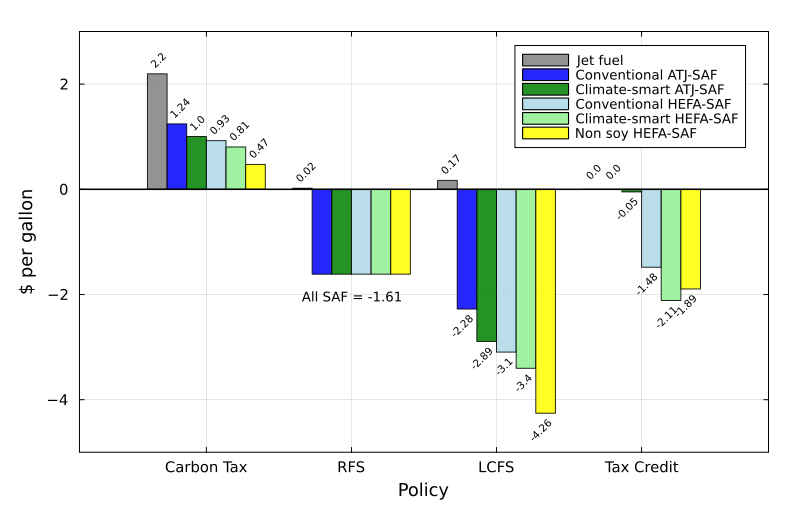

In [ ]:
# implicit tax calculation
results["implicit_tax"] = Dict(("x$i" => zeros(17)) for i in 1:6)
delta = params[:coeff][:delta]

for i in 1:6
    results["implicit_tax"]["x$i"][2] = t * delta[i]
end

gamma_aviation = results["shadow_values"]["rfs_aviation"][3]
results["implicit_tax"]["x1"][3] = gamma_aviation * theta_avi

for i in 2:6
    results["implicit_tax"]["x$i"][3] = -1.6 * gamma_aviation
end

μ = results["shadow_values"]["lcfs_aviation"][4]
for i in 1:6
    results["implicit_tax"]["x$i"][4] = -1 * μ * (delta[i] - sigma*delta[1])
end

results["implicit_tax"]["x1"][5] = p * emission_factor(kgCO2epermmbtu(delta_mj[1]))
results["implicit_tax"]["x2"][5] = p * emission_factor(kgCO2epermmbtu(delta_mj[2]))
results["implicit_tax"]["x3"][5] = -p * emission_factor(kgCO2epermmbtu(delta_mj[3]))
results["implicit_tax"]["x4"][5] = -p * emission_factor(kgCO2epermmbtu(delta_mj[4]))
results["implicit_tax"]["x5"][5] = -p * emission_factor(kgCO2epermmbtu(delta_mj[5]))
results["implicit_tax"]["x6"][5] = -p * emission_factor(kgCO2epermmbtu(delta_mj[6]))

# graph
Scenarios = ["Statusquo", "CarbonTax", "RFS", "LCFS", "TaxCredit"]
fuel_types = params[:meta][:process][1:6]

using Plots, StatsPlots, Statistics, Measures  

function plot_implicit_tax_clean(results, params)
    policies   = ["Carbon Tax","RFS","LCFS","Tax Credit"]
    fuel_types = ["Jet fuel","Conventional ATJ-SAF","Climate-smart ATJ-SAF",
                  "Conventional HEFA-SAF","Climate-smart HEFA-SAF","Non soy HEFA-SAF"]

                  tax_data = [results["implicit_tax"]["x$i"][p_idx+1] for i in 1:6, p_idx in 1:4]

    label_matrix = permutedims(fuel_types)
    
    bar_width = 0.65
    n_bars = 6
    
    policy_positions = [1.0, 1.8, 2.6, 3.4]
    
    fig = groupedbar(
        policy_positions,                  
        tax_data',                         
        bar_position = :dodge,
        bar_width = bar_width,
        label = label_matrix,
        xlabel = "Policy",
        ylabel = "\$ per gallon",
        xticks = (policy_positions, policies),  
        xlims = (0.3, 4.1),              
        ylims = (-5, 3),
        color = [:grey :blue :green :lightblue :lightgreen :yellow],
        alpha = 0.85,
        size = (800, 520),               
        framestyle = :box,
        legend = :topright,
        legendfontsize = 9,
        guidefontsize = 12,
        tickfontsize = 10,
        margin = 6mm,
    )
    
    for (i, policy) in enumerate(1:4)
        for (j, fuel) in enumerate(1:6)
            val = tax_data[j, policy]
            
            if policy == 2 && j > 1  
                continue
            end
            
            total_width = bar_width
            bar_width_individual = total_width / n_bars
            x_pos = policy_positions[i] - total_width/2 + bar_width_individual/2 + (j-1) * bar_width_individual
            
            if val > 0
                y_pos = val + 0.08
                h_align = :left
                v_align = :bottom
            elseif val < 0
                y_pos = val - 0.08
                h_align = :right
                v_align = :top
            else # val == 0
                y_pos = 0.15
                h_align = :left
                v_align = :bottom
            end
            
            rounded_val = round(val, digits=2)
            if rounded_val == 0.0 && val > 0
                label_text = "+0.0"
            else
                label_text = string(rounded_val)
            end
            
            annotate!(fig, x_pos, y_pos,
                text(label_text, h_align, v_align, :black, 7, rotation=45))
        end
    end
    
    saf_avg = round(mean(tax_data[2:6, 2]), digits=2)
    annotate!(fig, policy_positions[2], saf_avg - 0.3,
        text("All SAF = " * string(saf_avg), :black, :top, 9))
    
    hline!(fig, [0], color=:black, linewidth=1.5, label="")
    
    return fig
end

implicit_tax_plot = plot_implicit_tax_clean(results, params)
display(implicit_tax_plot)


Table 2. Aviation results

In [ ]:
using Printf

clean_small(val, threshold=1e-4) = abs(val) < threshold ? 0.0 : val

results["derived"] = Dict(
    "total_saf" => [],
    "saf_share_aviation" => [],
    "climate_smart_share_saf" => [],
    "conventional_saf" => [],
    "climate_smart_saf" => []
)

Scenarios = ["Status quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]

for policy in 1:5
    x = Dict(i => clean_small(results["variables"][params[:meta][:process][i]][policy]) for i in 1:6)
    
    # Conventional SAF = x2 + x4
    conv_saf = x[2] + x[4]
    push!(results["derived"]["conventional_saf"], conv_saf)
    
    # Climate-smart SAF = x3 + x5
    cs_saf = x[3] + x[5]
    push!(results["derived"]["climate_smart_saf"], cs_saf)
    
    # Total SAF = x2 + x3 + x4 + x5 + x6
    total_saf = conv_saf + cs_saf + x[6]
    push!(results["derived"]["total_saf"], total_saf)
    
    # SAF share in aviation fuel (%)
    total_aviation = results["production"]["aviation"][policy]
    saf_share = total_saf < 1e-10 ? 0.0 : (total_saf / total_aviation * 100)
    push!(results["derived"]["saf_share_aviation"], saf_share)
    
    # Climate-smart share in SAF (%)
    cs_share = (cs_saf < 1e-10 || total_saf < 1e-10) ? 0.0 : (cs_saf / total_saf * 100)
    push!(results["derived"]["climate_smart_share_saf"], cs_share)
end

println("\n===== Table 2: Effects of SAF policies on consumption and share =====\n")

@printf("%-40s", "Scenarios")
for scenario in Scenarios
    @printf("%15s", scenario)
end
println("\n")


table_rows = [
    ("Aviation fuel consumptions (billion gallons)", "", "", 0),
    ("Jet Fuel (x1)", "variables", params[:meta][:process][1], 4),
    ("Conventional ATJ-SAF (x2)", "variables", params[:meta][:process][2], 4),
    ("Climate-Smart ATJ-SAF (x3)", "variables", params[:meta][:process][3], 4),
    ("Conventional HEFA-SAF (x4)", "variables", params[:meta][:process][4], 4),
    ("Climate-Smart HEFA-SAF (x5)", "variables", params[:meta][:process][5], 4),
    ("Non-soy HEFA-SAF (x6)", "variables", params[:meta][:process][6], 4),
    ("Total Conventional SAF (x2+x4)", "derived", "conventional_saf", 4),
    ("Total Climate-Smart SAF (x3+x5)", "derived", "climate_smart_saf", 4),
    ("Total SAF (x2+x3+x4+x5+x6)", "derived", "total_saf", 4),
    ("Total Aviation Fuel", "production", "aviation", 2),
    ("", "", "", 0),
    ("SAF share (%)", "", "", 0),
    ("SAF in blended aviation fuel", "derived", "saf_share_aviation", 2),
    ("Climate-smart SAF in SAF blend", "derived", "climate_smart_share_saf", 2),
    ("", "", "", 0),
    ("Revenue-passenger mile consumption", "", "", 0),
    ("RPM (billion miles)", "production", "rpm", 2)
]


for (label, category, key, decimals) in table_rows
    if category == ""
       
        println(label)
        continue
    end
    
    @printf("%-40s", label)
    for policy in 1:5
        val = clean_small(results[category][key][policy])
        if decimals == 2
            @printf("%15.2f", val)
        elseif decimals == 4
            @printf("%15.4f", val)
        else
            @printf("%15.0f", val)
        end
    end
    println()
    
    if !contains(lowercase(label), "share") && !contains(lowercase(label), "consumption")
        @printf("%-40s%15s", "", "")
        
        for policy in 2:5
            baseline = clean_small(results[category][key][1])
            current = clean_small(results[category][key][policy])
            
            if baseline > 1e-10
                pct = ((current - baseline) / baseline) * 100
                @printf("%15s", "($(round(pct, digits=2))%)")
            else
                @printf("%15s", "(N/A)")
            end
        end
        println()
    end
    println()
end

println("="^120)


===== Table 2: Effects of SAF policies on consumption and share =====

Scenarios                                    Status quo     Carbon Tax            RFS           LCFS     Tax Credit

Aviation fuel consumptions (billion gallons)
Jet Fuel (x1)                                   20.3945        19.3494        19.2792        19.2344        19.6033
                                                              (-5.12%)       (-5.47%)       (-5.69%)       (-3.88%)

Conventional ATJ-SAF (x2)                        0.0001         0.0000         0.0675         0.0383         0.0000
                                                             (-100.0%)    (54320.96%)    (30749.37%)      (-100.0%)

Climate-Smart ATJ-SAF (x3)                       0.0000         0.0000         0.0238         0.0135         0.0000
                                                                 (N/A)          (N/A)          (N/A)          (N/A)

Conventional HEFA-SAF (x4)                       0.0000         0.0

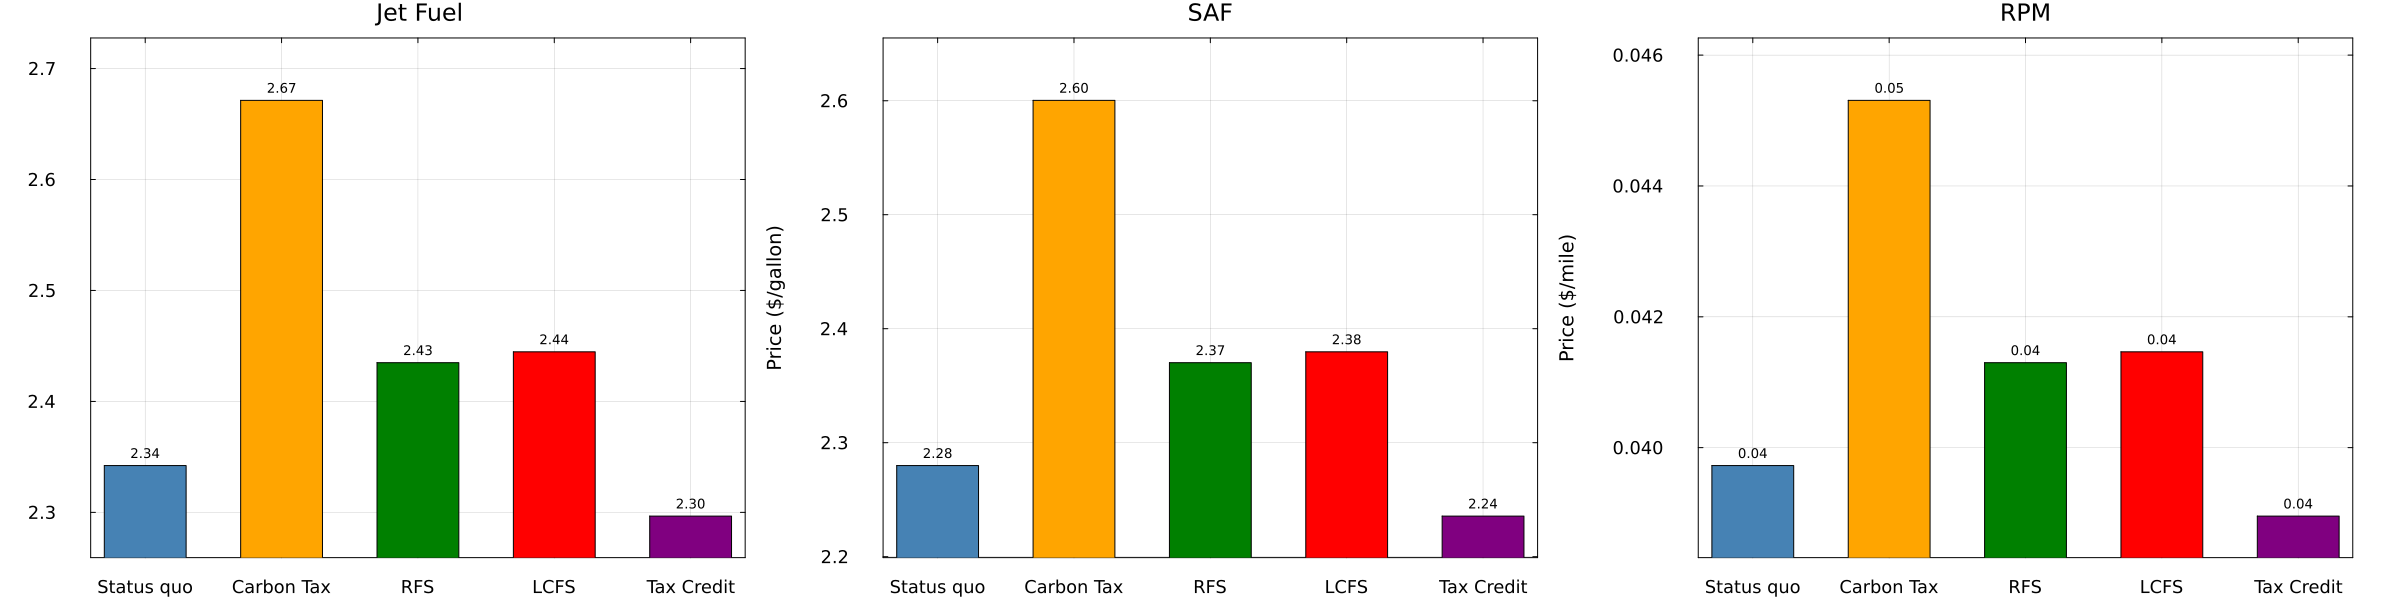

In [ ]:
using Plots, Printf

price_data = [
    ("Jet Fuel", "jet_fuel", "\$/gallon"),
    ("SAF", "SAF", "\$/gallon"),
    ("RPM", "rpm", "\$/mile")
]

colors = [:steelblue, :orange, :green, :red, :purple]

plots_array = []

for (title, key, unit) in price_data
    prices = [results["prices"][key][policy] for policy in 1:5]
    
    min_price = minimum(prices)
    max_price = maximum(prices)
    price_range = max_price - min_price
    y_min = min_price - price_range * 0.1
    y_max = max_price + price_range * 0.15

    title_f = font(16)     
    guide_f  = font(13)    
    tick_f   = font(12)    
    annot_f  = font(9)     

    price_plot = bar(
        1:5,
        prices,
        label = "",
        xlabel = "",
        ylabel = "Price ($unit)",
        title = title,
        xticks = (1:5, Scenarios),
        xrotation = 0,
        color = colors,
        size = (900, 520),
        grid = true,
        framestyle = :box,
        ylims = (y_min, y_max),
        bar_width = 0.6,           
        titlefont = title_f,
        guidefont = guide_f,
        tickfont = tick_f,
        legendfont = font(10),
        margin = 6mm,
        right_margin = 10mm,
        xlims = (0.6, 5.4)          
    )

    for (idx, price) in enumerate(prices)
        annotate!(price_plot, idx, price + price_range * 0.03,
                 text(@sprintf("%.2f", price), annot_f, :center, :black))
    end

    push!(plots_array, price_plot)
end

combined_plot = plot(
    plots_array...,
    layout = (1, 3),
    size = (2400, 600),
    margin = 5Plots.mm
)

display(combined_plot)


In [ ]:
using Printf

clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

println("\n===== Table 3: Road Vehicle Fuel and Food Consumption =====\n")

@printf("%-40s", "Scenarios")
for scenario in Scenarios
    @printf("%15s", scenario)
end
println("\n")

table3_rows = [
    ("Road vehicle fuel consumption (billion gallons)", "", "", false),
    ("Gasoline (x7)", "variables", params[:meta][:process][7], true),
    ("Ethanol (x8)", "variables", params[:meta][:process][8], true),
    ("Diesel (x9)", "variables", params[:meta][:process][9], true),
    ("Biodiesel (x10+x11)", "biodiesel_total", "", true),
    ("  Soy Biodiesel (x10)", "variables", params[:meta][:process][10], true),
    ("  Non-soy Biodiesel (x11)", "variables", params[:meta][:process][11], true),
    ("Renewable Diesel (x12+x13)", "renewable_diesel_total", "", true),
    ("  Soy Renewable Diesel (x12)", "variables", params[:meta][:process][12], true),
    ("  Non-soy Renewable Diesel (x13)", "variables", params[:meta][:process][13], true),
    ("Total Road Gasoline", "production", "road_gasoline", true),
    ("Total Road Diesel", "production", "road_diesel", true),
    ("", "", "", false),
    ("Vehicle-mile-traveled (billion miles)", "", "", false),
    ("VMT: Gasoline", "production", "vmt_gasoline", true),
    ("VMT: Diesel", "production", "vmt_diesel", true),
    ("", "", "", false),
    ("Food consumption", "", "", false),
    ("Food: Corn (billion bushels)", "production", "food_corn", true),
    ("Food: Soy oil (billion lbs)", "production", "food_soy", true),
    ("", "", "", false),
    ("Prices", "", "", false),
    ("Gasoline (\$/gallon)", "prices", "gasoline", false),
    ("Ethanol (\$/gallon)", "prices", "ethanol", false),
    ("Diesel (\$/gallon)", "prices", "diesel", false),
    ("Biodiesel (\$/gallon)", "prices", "biodiesel_soy", false),
    ("Renewable Diesel (\$/gallon)", "prices", "renewable_diesel_soy", false),
    ("Food: Corn (\$/bushel)", "prices", "food_corn", false),
    ("Food: Soy oil (\$/lb)", "prices", "food_soy", false),
    ("VMT: Gasoline (\$/mile)", "prices", "vmt_gasoline", false),
    ("VMT: Diesel (\$/mile)", "prices", "vmt_diesel", false)
]

for (label, category, key, show_pct) in table3_rows
    if category == ""
        println(label)
        continue
    elseif category == "biodiesel_total"
        # Biodiesel sum (x10 + x11)
        @printf("%-40s", label)
        totals = []
        for policy in 1:5
            bd_soy = clean_small(results["variables"][params[:meta][:process][10]][policy])
            bd_nonsoy = clean_small(results["variables"][params[:meta][:process][11]][policy])
            total = bd_soy + bd_nonsoy
            push!(totals, total)
            @printf("%15.4f", total)
        end
        println()
        
        # percentage change
        if show_pct
            @printf("%-40s%15s", "", "")
            for policy in 2:5
                if totals[1] > 1e-10
                    pct = ((totals[policy] - totals[1]) / totals[1]) * 100
                    @printf("%15s", "($(round(pct, digits=2))%)")
                else
                    @printf("%15s", "(N/A)")
                end
            end
            println()
        end
        println()
        
    elseif category == "renewable_diesel_total"
        # Renewable Diesel sum (x12 + x13)
        @printf("%-40s", label)
        totals = []
        for policy in 1:5
            rd_soy = clean_small(results["variables"][params[:meta][:process][12]][policy])
            rd_nonsoy = clean_small(results["variables"][params[:meta][:process][13]][policy])
            total = rd_soy + rd_nonsoy
            push!(totals, total)
            @printf("%15.4f", total)
        end
        println()
        
        # percentage change
        if show_pct
            @printf("%-40s%15s", "", "")
            for policy in 2:5
                if totals[1] > 1e-10
                    pct = ((totals[policy] - totals[1]) / totals[1]) * 100
                    @printf("%15s", "($(round(pct, digits=2))%)")
                else
                    @printf("%15s", "(N/A)")
                end
            end
            println()
        end
        println()
        
    else
        @printf("%-40s", label)
        for policy in 1:5
            val = clean_small(results[category][key][policy])
            @printf("%15.4f", val)
        end
        println()
        
        if show_pct
            @printf("%-40s%15s", "", "")
            for policy in 2:5
                baseline = clean_small(results[category][key][1])
                current = clean_small(results[category][key][policy])
                
                if baseline > 1e-10
                    pct = ((current - baseline) / baseline) * 100
                    @printf("%15s", "($(round(pct, digits=4))%)")
                else
                    @printf("%15s", "(N/A)")
                end
            end
            println()
        end
        println()
    end
end

println("="^120)


===== Table 3: Road Vehicle Fuel and Food Consumption =====

Scenarios                                    Status quo     Carbon Tax            RFS           LCFS     Tax Credit

Road vehicle fuel consumption (billion gallons)
Gasoline (x7)                                  127.0095       127.0028       126.9233       126.9594       126.9397
                                                            (-0.0053%)     (-0.0679%)     (-0.0395%)     (-0.0549%)

Ethanol (x8)                                    14.1121        14.1114        14.1026        14.1066        14.1044
                                                            (-0.0053%)     (-0.0679%)     (-0.0395%)     (-0.0549%)

Diesel (x9)                                     44.6573        44.6571        44.6537        44.6542        44.5383
                                                            (-0.0003%)     (-0.0079%)     (-0.0069%)     (-0.2664%)

Biodiesel (x10+x11)                              2.2134         2.2102    

In [362]:
using Plots
using Printf

# Calculate percentage changes relative to status quo (policy 1)
function calculate_price_changes(results)
    # Status quo prices (policy 1)
    base_rpm = results["prices"]["rpm"][1]
    base_vmt_gas = results["prices"]["vmt_gasoline"][1]
    base_vmt_diesel = results["prices"]["vmt_diesel"][1]
    base_food_corn = results["prices"]["food_corn"][1]
    base_food_soy = results["prices"]["food_soy"][1]
    
    # Calculate percentage changes for policies 2-5
    price_changes = Dict(
        "aviation" => [],
        "road_gasoline" => [],
        "road_diesel" => [],
        "food_corn" => [],
        "food_soy" => []
    )
    
    for i in 2:5
        # Aviation (using rpm as representative)
        push!(price_changes["aviation"], 
              (results["prices"]["rpm"][i] - base_rpm) / base_rpm * 100)
        
        # Road Gasoline (using vmt_gasoline as representative)
        push!(price_changes["road_gasoline"], 
              (results["prices"]["vmt_gasoline"][i] - base_vmt_gas) / base_vmt_gas * 100)
        
        # Road Diesel (using vmt_diesel as representative)
        push!(price_changes["road_diesel"], 
              (results["prices"]["vmt_diesel"][i] - base_vmt_diesel) / base_vmt_diesel * 100)
        
        # Food Corn
        push!(price_changes["food_corn"], 
              (results["prices"]["food_corn"][i] - base_food_corn) / base_food_corn * 100)
        
        # Food Soy
        push!(price_changes["food_soy"], 
              (results["prices"]["food_soy"][i] - base_food_soy) / base_food_soy * 100)
    end
    
    return price_changes
end

# Calculate price changes
price_changes = calculate_price_changes(results)

# Policy names and colors
policy_names = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]
bar_colors = [:yellow, :green, :blue, :orange]

# Sector information
sectors = [
    ("aviation", "(a) Aviation"),
    ("road_gasoline", "(b) Road: Gasoline"),
    ("road_diesel", "(c) Road: Diesel"),
    ("food_corn", "(d) Food: Corn"),
    ("food_soy", "(e) Food: Soy")
]

# Create subplots (1x5 layout)
plots_array = []

for (idx, (sector_key, sector_title)) in enumerate(sectors)
    
    if sector_key == "aviation"
        # Special handling for Aviation with two-part y-axis
        y_values = price_changes[sector_key]
        
        # Define break points in ACTUAL values
        lower_min = -1
        lower_max = 5  # Lower section: -1 to 5
        upper_min = 80  # Upper section: 80 to 85
        upper_max = 83  # Reduced from 85 to make more compact
        
        # Define break in DISPLAY coordinates
        gap_size = 0.6  # Reduced gap
        lower_display_max = lower_max
        upper_display_start = lower_display_max + gap_size
        
        p = plot(size = (300, 350), framestyle = :box, legend = false)
        
        # Draw bars
        for i in 1:4
            val = y_values[i]
            
            if val >= lower_min && val <= lower_max
                # Bar fits entirely in lower section
                bar!(p, [i], [val], 
                     color = bar_colors[i],
                     label = "",
                     bar_width = 0.6,
                     bottom = 0)
            elseif val < lower_min
                # Negative bar
                bar!(p, [i], [val], 
                     color = bar_colors[i],
                     label = "",
                     bar_width = 0.6,
                     bottom = 0)
            elseif val >= upper_min
                # Bar needs to be split: lower part (0 to 5) + upper part (80 to val)
                
                # Lower part: 0 to 5
                bar!(p, [i], [lower_max], 
                     color = bar_colors[i],
                     label = "",
                     bar_width = 0.6,
                     bottom = 0)
                
                # Upper part: manual rectangle
                upper_height = val - upper_min
                
                bar_width_val = 0.6
                x_left = i - bar_width_val/2
                x_right = i + bar_width_val/2
                
                y_bottom = upper_display_start
                y_top = upper_display_start + upper_height
                
                # Draw filled rectangle
                plot!(p, 
                      Shape([x_left, x_right, x_right, x_left], 
                            [y_bottom, y_bottom, y_top, y_top]),
                      fillcolor = bar_colors[i],
                      linecolor = :black,
                      linewidth = 0.5,
                      fillalpha = 1.0,
                      label = "")
            end
        end
        
        # Calculate total display height
        upper_display_range = upper_max - upper_min
        total_display_height = lower_display_max + gap_size + upper_display_range
        
        # Set plot properties
        plot!(p,
            title = sector_title,
            xlabel = "",
            ylabel = "",
            ylims = (lower_min - 0.3, total_display_height + 0.3),
            grid = false,
            gridalpha = 0.3,
            gridstyle = :dash,
            xticks = (1:4, ["", "", "", ""]),
            tickfontsize = 8,
            titlefontsize = 10,
            yticks = ([lower_min, 0, 2.5, lower_max, upper_display_start, upper_display_start + 1.5], 
                     ["-1", "0", "", "5", "80", ""]),
            left_margin = 1Plots.mm,
            right_margin = 2Plots.mm
        )
        
        # Add horizontal reference line at 0
        hline!(p, [0], linestyle=:solid, color=:black, linewidth=1, label="")
        
        # Add dense zigzag pattern (like hatching) ONLY on Carbon Tax bar
        break_y_start = lower_max
        break_y_end = upper_display_start
        bar_width_val = 0.6
        bar_center = 1
        bar_left = bar_center - bar_width_val/2
        bar_right = bar_center + bar_width_val/2
        
        # Draw many zigzag lines (hatching effect)
        n_lines = 15
        
        for i in 0:n_lines
            x1 = bar_left + (bar_right - bar_left) * i / n_lines
            x2 = x1 + (bar_right - bar_left) / (n_lines-1)
            
            if i % 2 == 0
                plot!(p, [x1, x2], [break_y_start, break_y_end], 
                      color=:black, linewidth=0.5, label="")
            else
                plot!(p, [x1, x2], [break_y_end, break_y_start], 
                      color=:black, linewidth=0.3, label="")
            end
        end
        
        # Add value labels
        for i in 1:4
            y_val = y_values[i]
            if y_val >= lower_min && y_val <= lower_max
                if y_val >= 0
                    y_offset = y_val + 0.3
                else
                    y_offset = y_val - 0.3
                end
            elseif y_val < lower_min
                y_offset = y_val - 0.3
            elseif y_val >= upper_min
                upper_height = y_val - upper_min
                y_offset = upper_display_start + upper_height + 0.3
            end
            annotate!(p, i, y_offset, 
                      text(@sprintf("%.1f%%", y_val), :center, 8, :black, :bold))
        end
        
    else
        # Normal handling for other sectors
        y_values = price_changes[sector_key]
        y_max = maximum(abs.(y_values))
        y_min = minimum(y_values)
        
        # Set y-axis limits more compact (1.2x instead of 1.5x)
        if y_min < 0
            y_limit_low = y_min * 1.2
            y_limit_high = y_max * 1.2
        else
            y_limit_low = 0
            y_limit_high = y_max * 1.2
        end
        
        p = plot(size = (300, 350), framestyle = :box)
        
        # Add each bar individually with its own color
        for i in 1:4
            bar!(p, [i], [y_values[i]], 
                 color = bar_colors[i],
                 label = "",
                 bar_width = 0.6)
        end
        
        # Set plot properties
        plot!(p,
            title = sector_title,
            xlabel = "",
            ylabel = "",
            legend = false,
            ylims = (y_limit_low, y_limit_high),
            grid = false,
            gridalpha = 0.3,
            gridstyle = :dash,
            xticks = (1:4, ["", "", "", ""]),
            tickfontsize = 8,
            titlefontsize = 10,
            left_margin = 1Plots.mm,
            right_margin = 2Plots.mm
        )
        
        # Add horizontal reference line at 0
        hline!(p, [0], linestyle=:solid, color=:black, linewidth=1, label="")
        
        # Add value labels on top/bottom of each bar
        for i in 1:4
            y_val = y_values[i]
            if y_val >= 0
                y_offset = y_val + (y_limit_high - y_limit_low) * 0.03
            else
                y_offset = y_val - (y_limit_high - y_limit_low) * 0.03
            end
            annotate!(p, i, y_offset, 
                      text(@sprintf("%.1f%%", y_val), :center, 8, :black, :bold))
        end
    end
    
    push!(plots_array, p)
end

# Combine all plots in 1x5 layout
combined_plot = plot(plots_array..., 
                     layout = (1, 5), 
                     size = (1600, 400),
                     margin = 0Plots.mm)

# Display the plot
display(combined_plot)

# Save the plot
savefig(combined_plot, "price_changes_by_sector.png")

println("\n=== Creating separate legend ===")

# Create separate legend - cleaner approach
legend_plot = plot(size = (800, 80), 
                   framestyle = :none,
                   grid = false,
                   showaxis = false)

# Draw colored rectangles manually
box_width = 0.05
box_height = 0.1
y_pos = 0.35
spacing = 0.2

for i in 1:4
    x_pos = 0.2 + (i-1) * spacing
    
    # Draw rectangle
    plot!(legend_plot,
          Shape([x_pos, x_pos + box_width, x_pos + box_width, x_pos],
                [y_pos - box_height/2, y_pos - box_height/2, y_pos + box_height/2, y_pos + box_height/2]),
          fillcolor = bar_colors[i],
          linecolor = :black,
          linewidth = 1,
          label = "")
    
    # Add text label
    annotate!(legend_plot, x_pos + box_width + 0.01, y_pos,
              text(policy_names[i], :left, 9, :black))
end

plot!(legend_plot,
      xlims = (0, 1),
      ylims = (0, 1),
      xticks = false,
      yticks = false,
      legend = false,
      axis = nothing)

display(legend_plot)
savefig(legend_plot, "price_changes_legend.png")

UndefVarError: UndefVarError: `y_offset` not defined in local scope
Suggestion: check for an assignment to a local variable that shadows a global of the same name.

✓ Saved: table3_prices_combined.png


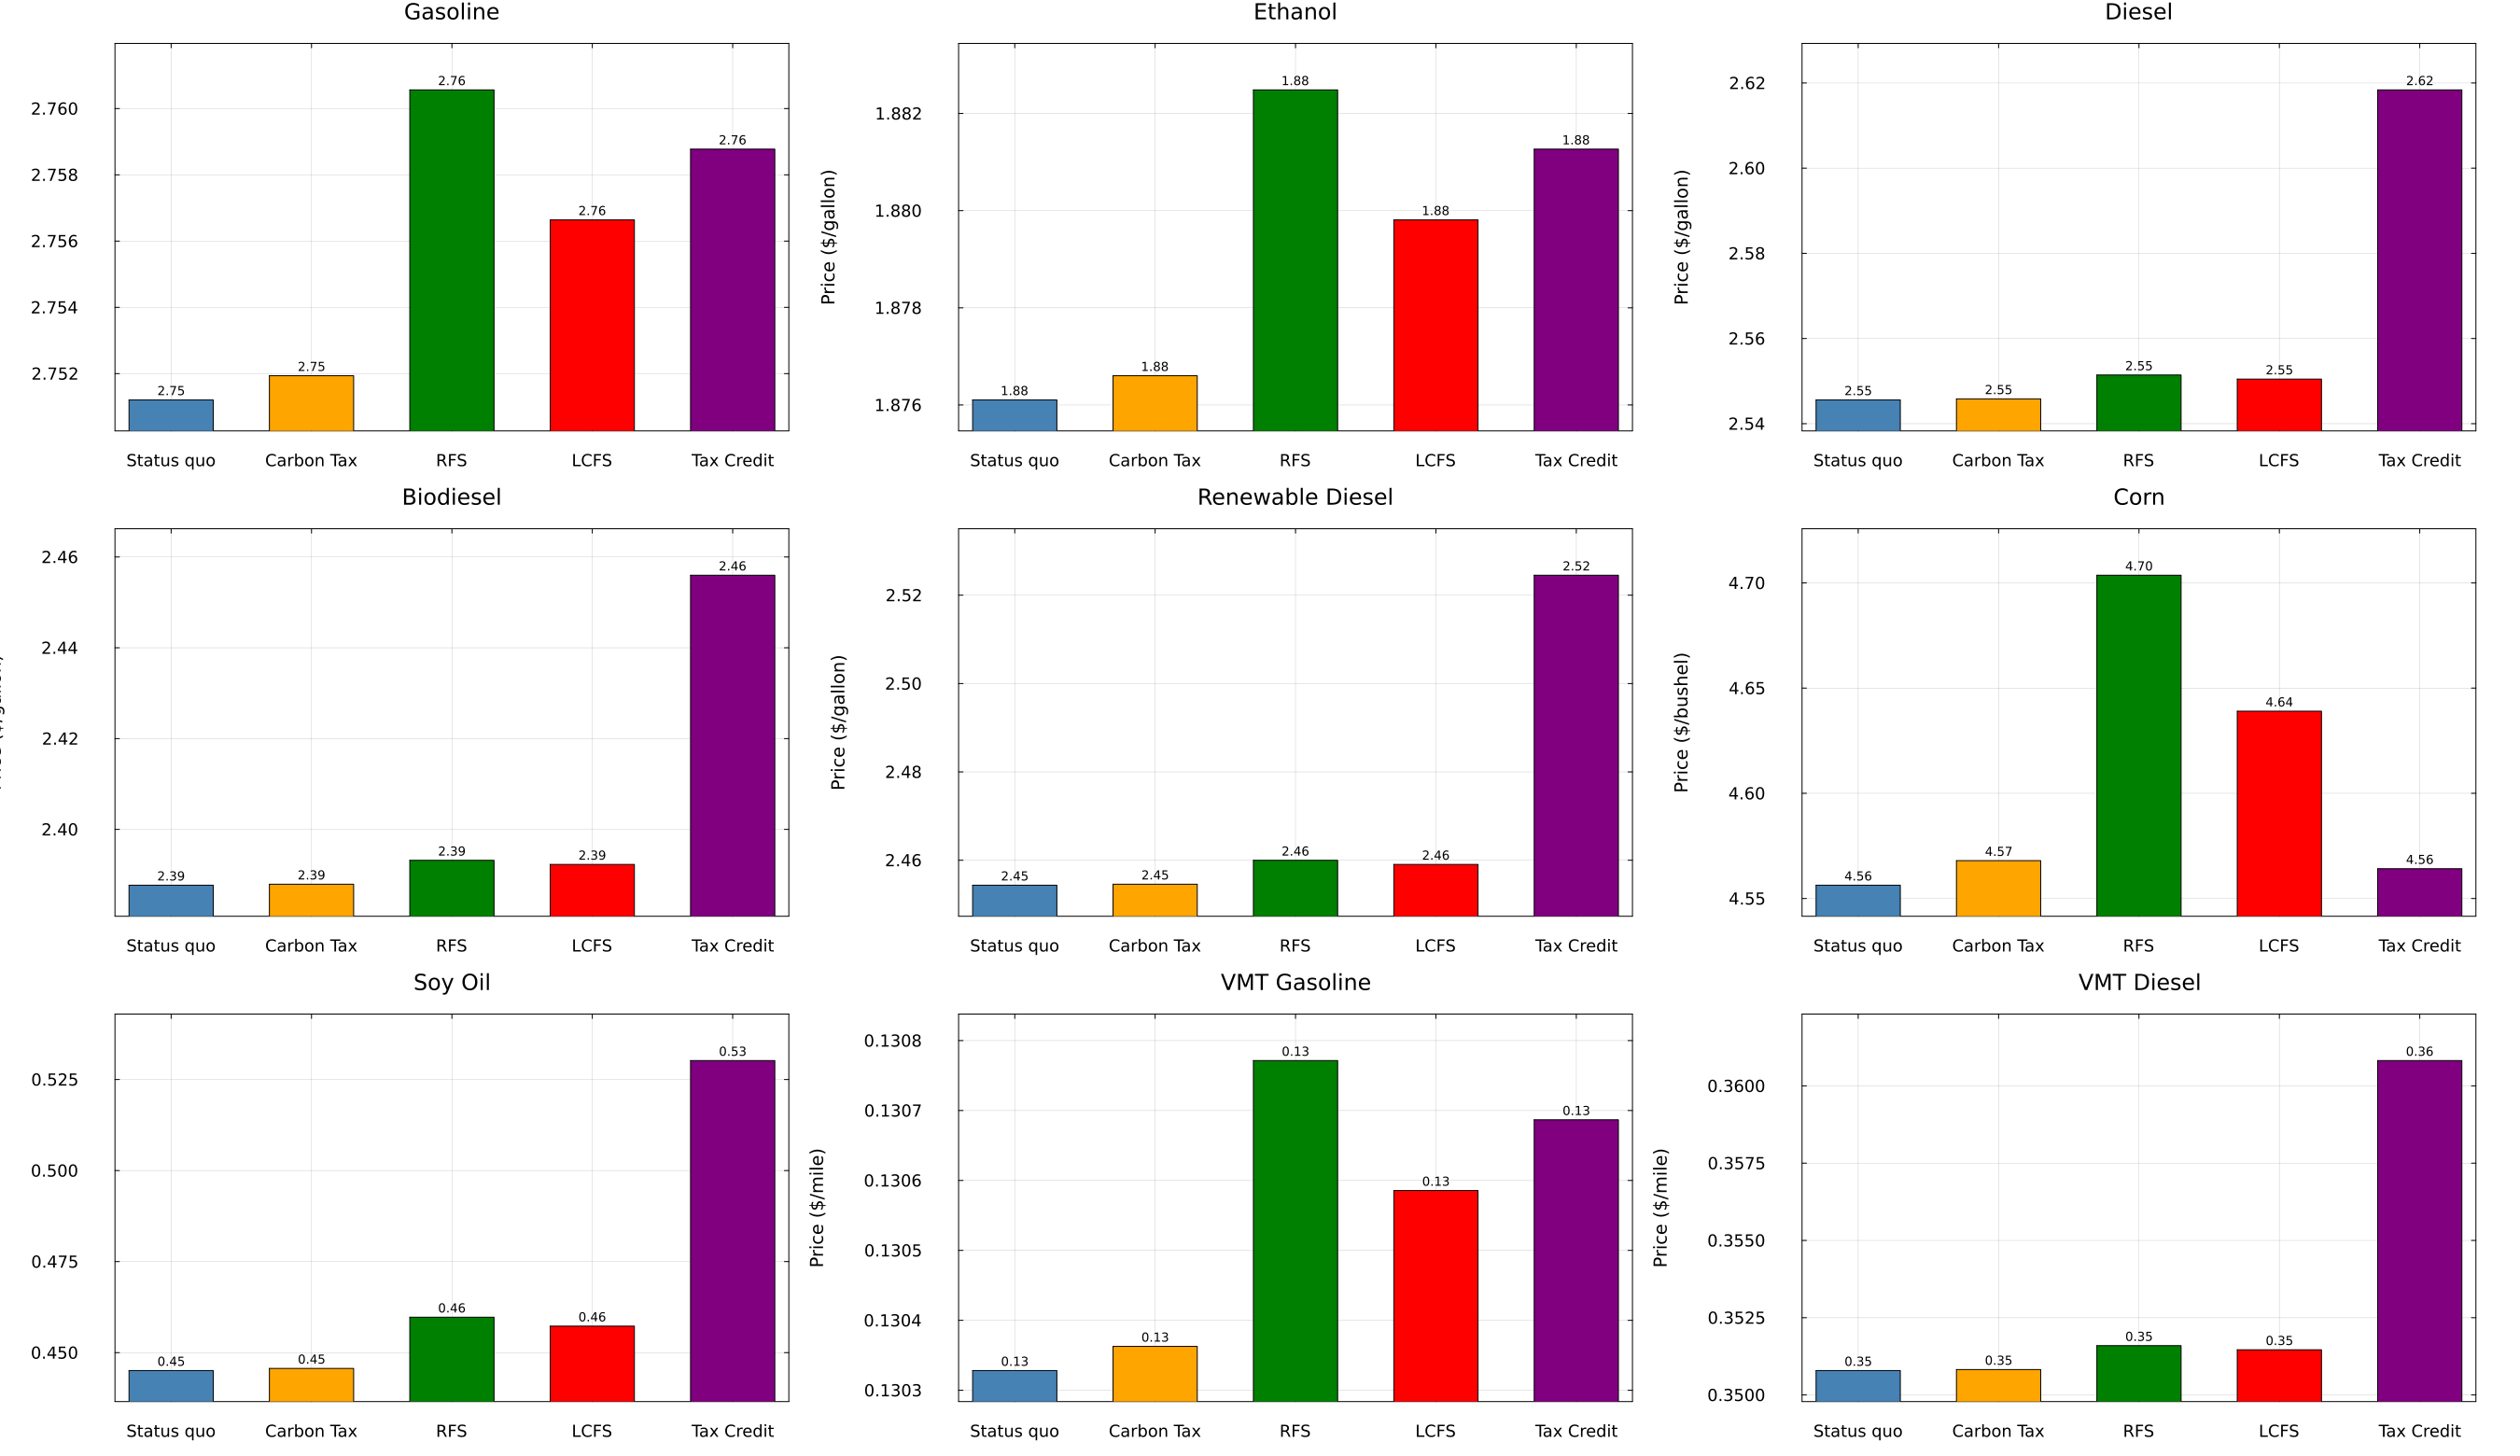

In [363]:
using Plots, Printf, Measures

function plot_table3_prices(results, params)
    # 시나리오 이름
    Scenarios = ["Status quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    # 가격 데이터 정의 (제목, 키, 단위)
    price_data = [
        ("Gasoline", "gasoline", "\$/gallon"),
        ("Ethanol", "ethanol", "\$/gallon"),
        ("Diesel", "diesel", "\$/gallon"),
        ("Biodiesel", "biodiesel_soy", "\$/gallon"),
        ("Renewable Diesel", "renewable_diesel_soy", "\$/gallon"),
        ("Corn", "food_corn", "\$/bushel"),
        ("Soy Oil", "food_soy", "\$/lb"),
        ("VMT Gasoline", "vmt_gasoline", "\$/mile"),
        ("VMT Diesel", "vmt_diesel", "\$/mile")
    ]
    
    colors = [:steelblue, :orange, :green, :red, :purple]
    
    # 그래프를 저장할 배열
    plots_array = []
    
    # 각 가격 항목별로 그래프 생성
    for (title, key, unit) in price_data
        # 해당 항목의 가격 데이터 추출
        prices = [results["prices"][key][policy] for policy in 1:5]
        
        # y축 범위를 데이터에 맞게 조정 (변화량이 잘 보이도록)
        min_price = minimum(prices)
        max_price = maximum(prices)
        price_range = max_price - min_price
        y_min = min_price - price_range * 0.1
        y_max = max_price + price_range * 0.15
        
        # 그래픽 폰트/크기 설정
        title_f = font(16)     # 제목
        guide_f = font(13)     # x/y 라벨
        tick_f = font(12)      # 눈금 숫자
        annot_f = font(9)      # 막대 위 텍스트
        
        # 막대그래프 생성
        price_plot = bar(
            1:5,
            prices,
            label = "",
            xlabel = "",
            ylabel = "Price ($unit)",
            title = title,
            xticks = (1:5, Scenarios),
            xrotation = 0,
            color = colors,
            size = (900, 520),
            grid = true,
            framestyle = :box,
            ylims = (y_min, y_max),
            bar_width = 0.6,
            titlefont = title_f,
            guidefont = guide_f,
            tickfont = tick_f,
            legendfont = font(10),
            margin = 6mm,
            right_margin = 10mm,
            xlims = (0.6, 5.4)
        )
        
        # 각 막대 위에 가격 표시
        for (idx, price) in enumerate(prices)
            annotate!(price_plot, idx, price + price_range * 0.03,
                     text(@sprintf("%.2f", price), annot_f, :center, :black))
        end
        
        push!(plots_array, price_plot)
    end
    
    return plots_array
end

function save_table3_price_plots(results, params, filename="table3_prices_combined.png")
    plots_array = plot_table3_prices(results, params)
    
    # 전체 그래프를 3x3 그리드로 결합
    combined_plot = plot(
        plots_array...,
        layout = (3, 3),
        size = (2700, 1560),
        margin = 5mm
    )
    
    savefig(combined_plot, filename)
    println("✓ Saved: $filename")
    
    return combined_plot
end

# 사용 예시:
 combined_plot = save_table3_price_plots(results, params, "table3_prices_combined.png")
 display(combined_plot)

In [ ]:
using Printf

clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

# land_derived
if !haskey(results, "land_derived")
    results["land_derived"] = Dict()
end

land_keys = [
    "corn_atj_saf", "corn_cs_atj_saf", "corn_ethanol", "corn_food", "corn_total",
    "corn_atj_share", "corn_cs_atj_share", "corn_ethanol_share", "corn_food_share",
    "soy_hefa_saf", "soy_cs_hefa_saf", "soy_biodiesel", "soy_rd", "soy_food", "soy_total",
    "soy_hefa_share", "soy_cs_hefa_share", "soy_biodiesel_share", "soy_rd_share", "soy_food_share",
    "climate_smart_land_share"
]

for key in land_keys
    results["land_derived"][key] = []
end

# calculate land use
for policy in 1:5
    # Corn land use (million acres)
    corn_atj = results["land_use"]["conventional_SAF_corn"][policy] * 1000
    corn_cs_atj = results["land_use"]["climate_smart_SAF_corn"][policy] * 1000
    corn_ethanol = results["land_use"]["ethanol"][policy] * 1000
    corn_food = results["land_use"]["food_corn"][policy] * 1000
    corn_total = results["land_use"]["corn_total"][policy] * 1000
    
    push!(results["land_derived"]["corn_atj_saf"], corn_atj)
    push!(results["land_derived"]["corn_cs_atj_saf"], corn_cs_atj)
    push!(results["land_derived"]["corn_ethanol"], corn_ethanol)
    push!(results["land_derived"]["corn_food"], corn_food)
    push!(results["land_derived"]["corn_total"], corn_total)
    
    # Corn shares (%)
    if corn_total > 1e-10
        push!(results["land_derived"]["corn_atj_share"], (corn_atj / corn_total) * 100)
        push!(results["land_derived"]["corn_cs_atj_share"], (corn_cs_atj / corn_total) * 100)
        push!(results["land_derived"]["corn_ethanol_share"], (corn_ethanol / corn_total) * 100)
        push!(results["land_derived"]["corn_food_share"], (corn_food / corn_total) * 100)
    else
        push!(results["land_derived"]["corn_atj_share"], 0.0)
        push!(results["land_derived"]["corn_cs_atj_share"], 0.0)
        push!(results["land_derived"]["corn_ethanol_share"], 0.0)
        push!(results["land_derived"]["corn_food_share"], 0.0)
    end
    
    # Soy land use (million acres)
    soy_hefa = results["land_use"]["conventional_SAF_soy"][policy] * 1000
    soy_cs_hefa = results["land_use"]["climate_smart_SAF_soy"][policy] * 1000
    soy_bd = results["land_use"]["biodiesel_soy"][policy] * 1000
    soy_rd = results["land_use"]["renewable_diesel_soy"][policy] * 1000
    soy_food = results["land_use"]["food_soy"][policy] * 1000
    soy_total = results["land_use"]["soy_total"][policy] * 1000
    
    push!(results["land_derived"]["soy_hefa_saf"], soy_hefa)
    push!(results["land_derived"]["soy_cs_hefa_saf"], soy_cs_hefa)
    push!(results["land_derived"]["soy_biodiesel"], soy_bd)
    push!(results["land_derived"]["soy_rd"], soy_rd)
    push!(results["land_derived"]["soy_food"], soy_food)
    push!(results["land_derived"]["soy_total"], soy_total)
    
    # Soy shares (%)
    if soy_total > 1e-10
        push!(results["land_derived"]["soy_hefa_share"], (soy_hefa / soy_total) * 100)
        push!(results["land_derived"]["soy_cs_hefa_share"], (soy_cs_hefa / soy_total) * 100)
        push!(results["land_derived"]["soy_biodiesel_share"], (soy_bd / soy_total) * 100)
        push!(results["land_derived"]["soy_rd_share"], (soy_rd / soy_total) * 100)
        push!(results["land_derived"]["soy_food_share"], (soy_food / soy_total) * 100)
    else
        push!(results["land_derived"]["soy_hefa_share"], 0.0)
        push!(results["land_derived"]["soy_cs_hefa_share"], 0.0)
        push!(results["land_derived"]["soy_biodiesel_share"], 0.0)
        push!(results["land_derived"]["soy_rd_share"], 0.0)
        push!(results["land_derived"]["soy_food_share"], 0.0)
    end
    
    # Climate-smart land use share
    climate_smart_land = corn_cs_atj + soy_cs_hefa
    total_land = corn_total + soy_total
    cs_share = total_land > 1e-10 ? (climate_smart_land / total_land) * 100 : 0.0
    push!(results["land_derived"]["climate_smart_land_share"], cs_share)
end

println("\n===== Table 4: Land Allocation Analysis =====\n")

@printf("%-40s", "Scenarios")
for scenario in Scenarios
    @printf("%15s", scenario)
end
println("\n")

land_table_rows = [
    ("Corn Land Use (million acres)", "", "", ""),
    ("  Conventional ATJ-SAF (x2)", "land_derived", "corn_atj_saf", "corn_atj_share"),
    ("  Climate-Smart ATJ-SAF (x3)", "land_derived", "corn_cs_atj_saf", "corn_cs_atj_share"),
    ("  Ethanol (x8)", "land_derived", "corn_ethanol", "corn_ethanol_share"),
    ("  Food (x14)", "land_derived", "corn_food", "corn_food_share"),
    ("Total Corn Land", "land_derived", "corn_total", ""),
    ("Land Shadow Price (\$/acre)", "shadow_corn", "", ""),
    ("", "", "", ""),
    ("Soy Land Use (million acres)", "", "", ""),
    ("  Conventional HEFA-SAF (x4)", "land_derived", "soy_hefa_saf", "soy_hefa_share"),
    ("  Climate-Smart HEFA-SAF (x5)", "land_derived", "soy_cs_hefa_saf", "soy_cs_hefa_share"),
    ("  Biodiesel (x10)", "land_derived", "soy_biodiesel", "soy_biodiesel_share"),
    ("  Renewable Diesel (x12)", "land_derived", "soy_rd", "soy_rd_share"),
    ("  Food (x15)", "land_derived", "soy_food", "soy_food_share"),
    ("Total Soy Land", "land_derived", "soy_total", ""),
    ("Land Shadow Price (\$/acre)", "shadow_soy", "", ""),
    ("", "", "", ""),
    ("Climate-Smart Land Use Share (%)", "", "", ""),
    ("(CS ATJ-SAF + CS HEFA-SAF) / Total", "land_derived", "climate_smart_land_share", "")
]

for (label, category, key, share_key) in land_table_rows
    if category == ""
        println(label)
        continue
    elseif category == "shadow_corn"
        # Corn land shadow price
        @printf("%-40s", label)
        for policy in 1:5
            val = clean_small(results["shadow_values"]["land_corn"][policy])
            if isnan(val)
                @printf("%15s", "N/A")
            else
                @printf("%15.2f", abs(val))
            end
        end
        println()
        println()
    elseif category == "shadow_soy"
        # Soy land shadow price
        @printf("%-40s", label)
        for policy in 1:5
            val = clean_small(results["shadow_values"]["land_soy"][policy])
            if isnan(val)
                @printf("%15s", "N/A")
            else
                @printf("%15.2f", abs(val))
            end
        end
        println()
        println()
    else
        @printf("%-40s", label)
        for policy in 1:5
            val = clean_small(results[category][key][policy])
            @printf("%15.2f", val)
        end
        println()
        
        if share_key != ""
            @printf("%-40s", "")
            for policy in 1:5
                share_val = clean_small(results[category][share_key][policy])
                @printf("%15s", "($(round(share_val, digits=2))%)")
            end
            println()
        end
        println()
    end
end

println("="^120)


===== Table 4: Land Allocation Analysis =====

Scenarios                                    Status quo     Carbon Tax            RFS           LCFS     Tax Credit

Corn Land Use (million acres)
  Conventional ATJ-SAF (x2)                        0.00           0.00           0.22           0.13           0.00
                                                 (0.0%)         (0.0%)        (0.33%)        (0.19%)         (0.0%)

  Climate-Smart ATJ-SAF (x3)                       0.00           0.00           0.09           0.05           0.00
                                                 (0.0%)         (0.0%)        (0.13%)        (0.07%)         (0.0%)

  Ethanol (x8)                                    27.06          27.06          27.04          27.05          27.04
                                               (40.34%)       (40.35%)       (40.31%)       (40.32%)       (40.33%)

  Food (x14)                                      40.02          40.00          39.73          39.85      

In [ ]:
using Printf

clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

println("\n===== Table 5: Effects of SAF policies on carbon emissions (Changes from Status Quo, million tonCO2e) =====\n")

scenarios = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]

@printf("%-35s", "")
for scenario in scenarios
    @printf("%18s", scenario)
end
println("\n")

emission_rows = [
    ("Aviation", "aviation", ["aviation"]),
    ("Road vehicle", "road_total", ["road_gasoline", "road_diesel"]),
    ("  Gasoline", "road_gasoline", ["road_gasoline"]),
    ("  Diesel", "road_diesel", ["road_diesel"]),
    ("Food", "food_total", ["food_corn", "food_soy"]),
    ("  Corn", "food_corn", ["food_corn"]),
    ("  Soy", "food_soy", ["food_soy"]),
    ("", "", []),
    ("Total changes", "total", ["total"])
]

for (label, category, keys) in emission_rows
    if category == ""
        println("-"^107)
        continue
    end
    
    @printf("%-35s", label)
    
    for policy in 2:5
        sq_value = sum(results["emissions"][key][1] for key in keys)
        current_value = sum(results["emissions"][key][policy] for key in keys)
        change = clean_small((current_value - sq_value) * 1000)
        @printf("%18.2f", change)
    end
    println()
end

println()
println("="^107)


===== Table 5: Effects of SAF policies on carbon emissions (Changes from Status Quo, million tonCO2e) =====

                                           Carbon Tax               RFS              LCFS        Tax Credit

Aviation                                       -12.08             -9.98            -10.70             -6.08
Road vehicle                                    -0.09             -1.21             -0.74             -2.59
  Gasoline                                      -0.08             -1.07             -0.62             -0.87
  Diesel                                        -0.01             -0.14             -0.11             -1.72
Food                                            -0.05             -0.98             -0.73             -3.50
  Corn                                          -0.03             -0.33             -0.19             -0.02
  Soy                                           -0.03             -0.65             -0.54             -3.48
-------------------------

In [ ]:
# ============================================
# PART 1: Welfare calculation
# ============================================

using Printf

# clean_small
clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

# === Consumer Surplus ===
calc_cs(A, k, q_policy, q_sq, p_policy, p_sq) = (A/(k+1)) * (q_policy^(k+1) - q_sq^(k+1)) - p_policy * q_policy + p_sq * q_sq

function calculate_cs(results, policy, demand)
    A_avi, k_avi = demand[:avi][:A], demand[:avi][:k]
    A_gas, k_gas = demand[:gas][:A], demand[:gas][:k]
    A_die, k_die = demand[:die][:A], demand[:die][:k]
    A_corn, k_corn = demand[:corn][:A], demand[:corn][:k]
    A_soy, k_soy = demand[:soy][:A], demand[:soy][:k]
    
    return Dict(
        "aviation" => calc_cs(A_avi, k_avi, 
            results["production"]["rpm"][policy], results["production"]["rpm"][1],
            results["prices"]["rpm"][policy], results["prices"]["rpm"][1]),
        "road_gasoline" => calc_cs(A_gas, k_gas, 
            results["production"]["vmt_gasoline"][policy], results["production"]["vmt_gasoline"][1], 
            results["prices"]["vmt_gasoline"][policy], results["prices"]["vmt_gasoline"][1]),
        "road_diesel" => calc_cs(A_die, k_die, 
            results["production"]["vmt_diesel"][policy], results["production"]["vmt_diesel"][1], 
            results["prices"]["vmt_diesel"][policy], results["prices"]["vmt_diesel"][1]),
        "food_corn" => calc_cs(A_corn, k_corn, 
            results["production"]["food_corn"][policy], results["production"]["food_corn"][1], 
            results["prices"]["food_corn"][policy], results["prices"]["food_corn"][1]),
        "food_soy" => calc_cs(A_soy, k_soy, 
            results["production"]["food_soy"][policy], results["production"]["food_soy"][1], 
            results["prices"]["food_soy"][policy], results["prices"]["food_soy"][1])
    )
end


calculate_cs (generic function with 1 method)

In [ ]:
# === Producer Surplus (hockey stick cost) ===
function calc_ps_hockey(x_policy, x_sq, p_policy, p_sq, t, c0, c1, c2, v, land_cost_policy)
    cost_policy = if x_policy <= v
        (p_policy - t) * x_policy - (c0*x_policy + 0.5*c1*x_policy^2) + land_cost_policy * x_policy
    else
        (p_policy - t) * x_policy - ((c0*v + 0.5*c1*v^2) + c0*(x_policy - v) + 0.5*c1*(x_policy^2 - v^2) + (c2/3)*(x_policy - v)^3) + land_cost_policy * x_policy
    end
    
    cost_sq = if x_sq <= v
        p_sq * x_sq - (c0*x_sq + 0.5*c1*x_sq^2)
    else
        p_sq * x_sq - ((c0*v + 0.5*c1*v^2) + c0*(x_sq - v) + 0.5*c1*(x_sq^2 - v^2) + (c2/3)*(x_sq - v)^3)
    end
    
    return cost_policy - cost_sq
end

# === Producer Surplus (isoelastic cost - food) ===
calc_ps_food(x_policy, x_sq, p_policy, p_sq, a, b, land_cost_policy) = 
    p_policy * x_policy - (x_policy^(b+1) / (a^b * (b+1))) + land_cost_policy * x_policy - p_sq * x_sq + (x_sq^(b+1) / (a^b * (b+1)))

function calculate_ps(results, policy, params)
    ps = Dict()
    coeff = params[:coeff]
    supply = params[:supply]
    Process = params[:meta][:process]
    
    # Aviation (x1-x6)
    ps["aviation"] = sum(1:6) do i
        x_policy = results["variables"][Process[i]][policy]
        x_sq = results["variables"][Process[i]][1]
        p_policy = i != 1 ? results["prices"]["SAF"][policy] : results["prices"]["jet_fuel"][policy]
        p_sq = i != 1 ? results["prices"]["SAF"][1] : results["prices"]["jet_fuel"][1]
        t = results["implicit_tax"]["x$i"][policy]
        
        land_cost_policy = i in [2,3] ? results["shadow_values"]["land_corn"][policy] * coeff[:alpha][i] :
                          i in [4,5] ? results["shadow_values"]["land_soy"][policy] * coeff[:alpha][i] : 0.0
        calc_ps_hockey(x_policy, x_sq, p_policy, p_sq, t, supply[:c0][i], supply[:c1][i], supply[:c2][i], supply[:v][i], land_cost_policy)
    end
    
    # Road Gasoline (x7-x8)
    ps["road_gasoline"] = sum(7:8) do i
        x_policy = results["variables"][Process[i]][policy]
        x_sq = results["variables"][Process[i]][1]
        p_policy = i == 7 ? results["prices"]["gasoline"][policy] : results["prices"]["ethanol"][policy]
        p_sq = i == 7 ? results["prices"]["gasoline"][1] : results["prices"]["ethanol"][1]
        t = 0

        land_cost_policy = i == 8 ? results["shadow_values"]["land_corn"][policy] * coeff[:alpha][i] : 0.0
        calc_ps_hockey(x_policy, x_sq, p_policy, p_sq, t, supply[:c0][i], supply[:c1][i], supply[:c2][i], supply[:v][i], land_cost_policy)
    end
    
    # Road Diesel (x9-x13)
    ps["road_diesel"] = sum(9:13) do i
        x_policy = results["variables"][Process[i]][policy]
        x_sq = results["variables"][Process[i]][1]
        p_policy = i == 9 ? results["prices"]["diesel"][policy] : (i in [10,11] ? results["prices"]["biodiesel_soy"][policy] : results["prices"]["renewable_diesel_soy"][policy])
        p_sq = i == 9 ? results["prices"]["diesel"][1] : (i in [10,11] ? results["prices"]["biodiesel_soy"][1] : results["prices"]["renewable_diesel_soy"][1])
        t = 0
        land_cost_policy = i in [10,12] ? results["shadow_values"]["land_soy"][policy] * coeff[:alpha][i] : 0.0
        calc_ps_hockey(x_policy, x_sq, p_policy, p_sq, t, supply[:c0][i], supply[:c1][i], supply[:c2][i], supply[:v][i], land_cost_policy)
    end
    
    # Food Corn (x14)
    i = 14
    x_policy, x_sq = results["variables"][Process[i]][policy], results["variables"][Process[i]][1]
    p_policy, p_sq = results["prices"]["food_corn"][policy], results["prices"]["food_corn"][1]
    land_cost_policy = results["shadow_values"]["land_corn"][policy] * coeff[:alpha][i]
    ps["food_corn"] = calc_ps_food(x_policy, x_sq, p_policy, p_sq, supply[:a][1], supply[:b][1], land_cost_policy)
    
    # Food Soy (x15)
    i = 15
    x_policy, x_sq = results["variables"][Process[i]][policy], results["variables"][Process[i]][1]
    p_policy, p_sq = results["prices"]["food_soy"][policy], results["prices"]["food_soy"][1]
    land_cost_policy = results["shadow_values"]["land_soy"][policy] * coeff[:alpha][i]
    ps["food_soy"] = calc_ps_food(x_policy, x_sq, p_policy, p_sq, supply[:a][2], supply[:b][2], land_cost_policy)
    
    return ps
end

calculate_ps (generic function with 1 method)

In [ ]:
using DataFrames, CSV, Printf

function display_ps_table(results, params)
    Process = params[:meta][:process]
    policies = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    # DataFrame
    df = DataFrame(
        Process_ID = String[], 
        Process_Name = String[],
        Carbon_Tax = Float64[],
        RFS = Float64[],
        LCFS = Float64[],
        Tax_Credit = Float64[]
    )
    
    # PS changes in billion $
    for i in 1:15
        ps_values = Float64[]
        for policy in 2:5  # Policy 2, 3, 4, 5
            ps = calculate_ps(results, policy, params)
            push!(ps_values, ps["x$i"] * 1000)
        end
        push!(df, ("x$i", Process[i], ps_values...))
    end
    
    push!(df, ("", "--- SECTOR TOTALS ---", 0.0, 0.0, 0.0, 0.0))
    
    sector_groups = [
        ("Aviation (x1-x6)", 1:6),
        ("Road Gasoline (x7-x8)", 7:8),
        ("Road Diesel (x9-x13)", 9:13),
        ("Food Corn (x14)", [14]),
        ("Food Soy (x15)", [15])
    ]
    
    for (sector_name, indices) in sector_groups
        sector_values = Float64[]
        for policy in 2:5
            ps = calculate_ps(results, policy, params)
            total = sum(ps["x$i"] for i in indices) * 1000
            push!(sector_values, total)
        end
        push!(df, ("", sector_name, sector_values...))
    end
    
    df_display = copy(df)
    for col in ["Carbon_Tax", "RFS", "LCFS", "Tax_Credit"]
        df_display[!, col] = round.(df[!, col], digits=2)
    end
    
    println("\n" * "="^100)
    println("Producer Surplus Changes from Status Quo (Billion \$)")
    println("="^100)
    show(df_display, allrows=true, allcols=true)
    println("\n" * "="^100)
    
    return df
end

df_ps = display_ps_table(results, params)



Producer Surplus Changes from Status Quo (Billion $)
21×6 DataFrame
 Row │ Process_ID  Process_Name              Carbon_Tax  RFS       LCFS      Tax_Credit 
     │ String      String                    Float64     Float64   Float64   Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────
   1 │ x1          Jet fuel                    -1194.15  -1272.13  -1321.7      -909.76
   2 │ x2          Conventional ATJ-SAF            0.05    102.85     33.09        0.06
   3 │ x3          Climate-smart ATJ-SAF           0.0      19.13      6.18        0.0
   4 │ x4          Conventional HEFA-SAF           0.01    259.78    176.25      246.95
   5 │ x5          Climate-smart HEFA-SAF         -0.0      48.7      36.2       225.57
   6 │ x6          Non soy HEFA-SAF                0.0     810.89   1133.73     2232.15
   7 │ x7          Gasoline                       92.6    1187.27    689.71      960.47
   8 │ x8          Ethanol                      -

21×6 DataFrame
 Row │ Process_ID  Process_Name            Carbon_Tax       RFS         LCFS   ⋯
     │ String      String                  Float64          Float64     Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ x1          Jet fuel                -1194.15         -1272.13    -1321. ⋯
   2 │ x2          Conventional ATJ-SAF        0.0489649      102.85       33.
   3 │ x3          Climate-smart ATJ-SAF       3.33009e-5      19.1321      6.
   4 │ x4          Conventional HEFA-SAF       0.00823246     259.782     176.
   5 │ x5          Climate-smart HEFA-SAF     -6.93291e-6      48.6984     36. ⋯
   6 │ x6          Non soy HEFA-SAF            0.000357496    810.891    1133.
   7 │ x7          Gasoline                   92.6046        1187.27      689.
   8 │ x8          Ethanol                  -100.023        -1242.24     -700.
  ⋮  │     ⋮                 ⋮                    ⋮             ⋮            ⋮ ⋱
  15 │ x15         Food: Soy oil              -8.05202       -193.174    -161. ⋯
  16 │             --- SECTOR TOTALS ---       0.0              0.0         0.
  17 │             Aviation (x1-x6)        -1194.09           -30.773      63.
  18 │             Road Gasoline (x7-x8)      -7.41806        -54.9648    -10.
  19 │             Road Diesel (x9-x13)       -4.99591        -99.3321    -86. ⋯
  20 │             Food Corn (x14)           -74.1397        -907.156    -516.
  21 │             Food Soy (x15)             -8.05202       -193.174    -161.
                                                    2 columns and 6 rows omitted

In [ ]:
# === Government Revenue ===
function calculate_gov_revenue(results, policy, params)
    Process = params[:meta][:process]
    gov_rev = 0.0

    # Carbon Tax
    if policy == 2
        for i in 1:6
            t_i = get(results["implicit_tax"], "x$(i)", Dict())[policy]
            q_i = results["variables"][Process[i]][policy]
            gov_rev += t_i * q_i
        end
        return gov_rev
    end

    # Tax Credit
    if policy == 5
        for i in 3:6
            s_i = get(results["implicit_tax"], "x$(i)", Dict())[policy]
            q_i = results["variables"][Process[i]][policy]
            gov_rev += s_i * q_i
        end
        return gov_rev
    end

    return 0.0
end


calculate_gov_revenue (generic function with 1 method)

In [ ]:
# === Welfare ===
function calculate_and_store_welfare!(results, params)
    
    results["welfare"] = Dict(
        "cs_aviation" => [],
        "ps_aviation" => [],
        "sw_aviation" => [],
        "government_revenue_aviation" => [],
        "DWL_aviation" => [],
        "cs_road_gasoline" => [],
        "ps_road_gasoline" => [],
        "sw_road_gasoline" => [],
        "cs_road_diesel" => [],
        "ps_road_diesel" => [],
        "sw_road_diesel" => [],
        "cs_food_corn" => [],
        "ps_food_corn" => [],
        "sw_food_corn" => [],
        "cs_food_soy" => [],
        "ps_food_soy" => [],
        "sw_food_soy" => [],
        "sw_total" => []
    )
    
    # Policy 1 (Status Quo) = 0
    for key in keys(results["welfare"])
        push!(results["welfare"][key], key == "DWL_aviation" ? NaN : 0.0)
    end
    
    # Policy 2-5
    for policy in 2:5
        cs = calculate_cs(results, policy, params[:demand])
        ps = calculate_ps(results, policy, params)
        gov_rev = calculate_gov_revenue(results, policy, params)
        
        # Store values
        push!(results["welfare"]["cs_aviation"], cs["aviation"])
        push!(results["welfare"]["ps_aviation"], ps["aviation"])
        push!(results["welfare"]["sw_aviation"], cs["aviation"] + ps["aviation"] + gov_rev )
        push!(results["welfare"]["government_revenue_aviation"], gov_rev)
        push!(results["welfare"]["DWL_aviation"], 
              policy in [2,5] ? -(cs["aviation"] + ps["aviation"] + gov_rev) : NaN)
        
        push!(results["welfare"]["cs_road_gasoline"], cs["road_gasoline"])
        push!(results["welfare"]["ps_road_gasoline"], ps["road_gasoline"])
        push!(results["welfare"]["sw_road_gasoline"], cs["road_gasoline"] + ps["road_gasoline"])
        
        push!(results["welfare"]["cs_road_diesel"], cs["road_diesel"])
        push!(results["welfare"]["ps_road_diesel"], ps["road_diesel"])
        push!(results["welfare"]["sw_road_diesel"], cs["road_diesel"] + ps["road_diesel"])
        
        push!(results["welfare"]["cs_food_corn"], cs["food_corn"])
        push!(results["welfare"]["ps_food_corn"], ps["food_corn"])
        push!(results["welfare"]["sw_food_corn"], cs["food_corn"] + ps["food_corn"])
        
        push!(results["welfare"]["cs_food_soy"], cs["food_soy"])
        push!(results["welfare"]["ps_food_soy"], ps["food_soy"])
        push!(results["welfare"]["sw_food_soy"], cs["food_soy"] + ps["food_soy"])
        
        sw_total = cs["aviation"] + ps["aviation"] + gov_rev +
                   cs["road_gasoline"] + ps["road_gasoline"] +
                   cs["road_diesel"] + ps["road_diesel"] + 
                   cs["food_corn"] + ps["food_corn"] +
                   cs["food_soy"] + ps["food_soy"]
        push!(results["welfare"]["sw_total"], sw_total)
        
        println("Welfare calculated for policy $policy")
    end
end

println("Calculating welfare...")
calculate_and_store_welfare!(results, params)
println("Welfare calculation complete!\n")

Calculating welfare...
Welfare calculated for policy 2
Welfare calculated for policy 3
Welfare calculated for policy 4
Welfare calculated for policy 5
Welfare calculation complete!



In [372]:
using Printf

# ============================================
# PART 2: Welfare Table 출력 (Million $)
# ============================================

function print_welfare_table(results, scc)
    println("\n" * "="^130)
    println("===== Economic Surplus and Social Welfare Analysis (Changes from Status Quo, Million \$) =====")
    println(" "^50 * "Carbon Tax" * " "^10 * "RFS" * " "^15 * "LCFS" * " "^12 * "Tax Credit")
    println("="^130)
    
    # Aviation Sector
    println("\nAviation Sector")
    
    # Consumer surplus (a1)
    @printf("%-50s", "Consumer (a1)")
    for policy in 2:5
        val = results["welfare"]["cs_aviation"][policy] * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Producer surplus (b1)
    @printf("%-50s", "Producer (b1)")
    for policy in 2:5
        val = results["welfare"]["ps_aviation"][policy] * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Government revenue (c) - RFS와 LCFS는 빈칸
    @printf("%-50s", "Government revenue (c)")
    for policy in 2:5
        if policy in [3, 4]  # RFS, LCFS
            @printf("%15s", "")
        else  # Carbon Tax, Tax Credit
            val = results["welfare"]["government_revenue_aviation"][policy] * 1000
            @printf("%15.2f", val)
        end
    end
    println()
    
    # Economic surplus (Δ1 = a1 + b1 + c)
    @printf("%-50s", "Economic surplus (Δ1 = a1 + b1 + c)")
    for policy in 2:5
        val = results["welfare"]["sw_aviation"][policy] * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Dead weight loss
    @printf("%-50s", "Dead weight loss")
    for policy in 2:5
        val = results["welfare"]["DWL_aviation"][policy]
        if isnan(val)
            @printf("%15s", "NaN")
        else
            @printf("%15.2f", val * 1000)
        end
    end
    println()
    
    # Road Vehicle Sector
    println("\nRoad Vehicle Sector")
    
    # Consumer (a2)
    @printf("%-50s", "Consumer (a2)")
    for policy in 2:5
        val = (results["welfare"]["cs_road_gasoline"][policy] + results["welfare"]["cs_road_diesel"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Producer (b2)
    @printf("%-50s", "Producer (b2)")
    for policy in 2:5
        val = (results["welfare"]["ps_road_gasoline"][policy] + results["welfare"]["ps_road_diesel"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Economic surplus (Δ2 = a2 + b2)
    @printf("%-50s", "Economic surplus (Δ2 = a2 + b2)")
    for policy in 2:5
        val = (results["welfare"]["sw_road_gasoline"][policy] + results["welfare"]["sw_road_diesel"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Food Sector
    println("\nFood Sector")
    
    # Consumer (a3)
    @printf("%-50s", "Consumer (a3)")
    for policy in 2:5
        val = (results["welfare"]["cs_food_corn"][policy] + results["welfare"]["cs_food_soy"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Producer (b3)
    @printf("%-50s", "Producer (b3)")
    for policy in 2:5
        val = (results["welfare"]["ps_food_corn"][policy] + results["welfare"]["ps_food_soy"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Economic surplus (Δ3 = a3 + b3)
    @printf("%-50s", "Economic surplus (Δ3 = a3 + b3)")
    for policy in 2:5
        val = (results["welfare"]["sw_food_corn"][policy] + results["welfare"]["sw_food_soy"][policy]) * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # All Sectors
    println("\nAll Sectors")
    
    # Economic surplus (Δ = Δ1 + Δ2 + Δ3)
    @printf("%-50s", "Economic surplus (Δ = Δ1 + Δ2 + Δ3)")
    for policy in 2:5
        val = results["welfare"]["sw_total"][policy] * 1000
        @printf("%15.2f", val)
    end
    println()
    
    # Reduction in externality costs (d)
    @printf("%-50s", "Reduction in externality costs (d)")
    for policy in 2:5
        # 배출량 감축 (billion ton → million ton)
        emission_reduction = (results["emissions"]["total"][1] - results["emissions"]["total"][policy]) * 1000
        # 외부비용 감소 (million ton × $/ton = million $)
        externality_reduction = emission_reduction * scc
        @printf("%15.2f", externality_reduction)
    end
    println()
    
    # Social welfare (Δ + d)
    @printf("%-50s", "Social welfare (Δ + d)")
    for policy in 2:5
        # Economic surplus
        total_delta = results["welfare"]["sw_total"][policy] * 1000
        
        # Externality reduction
        emission_reduction = (results["emissions"]["total"][1] - results["emissions"]["total"][policy]) * 1000
        externality_reduction = emission_reduction * scc
        
        social_welfare = total_delta + externality_reduction
        @printf("%15.2f", social_welfare)
    end
    println()
    
    println("="^130)
end

# 테이블 출력
scc = 190  # Social Cost of Carbon ($/ton CO2e)
print_welfare_table(results, scc)


===== Economic Surplus and Social Welfare Analysis (Changes from Status Quo, Million $) =====
                                                  Carbon Tax          RFS               LCFS            Tax Credit

Aviation Sector
Consumer (a1)                                            -6536.56       -1876.93       -2073.61         931.40
Producer (b1)                                            -1194.09         -30.77          63.76        1794.96
Government revenue (c)                                    7532.53                                     -5793.89
Economic surplus (Δ1 = a1 + b1 + c)                       -198.12       -1907.70       -2009.85       -3067.53
Dead weight loss                                           198.12            NaN            NaN        3067.53

Road Vehicle Sector
Consumer (a2)                                             -111.43       -1564.64        -981.61       -4596.89
Producer (b2)                                              -12.41        -154.30      

In [ ]:
using Printf

# ============================================
# PART 3: Implicit Carbon Price Analysis
# ============================================

# Initialize average_abatement_cost in results dict
if !haskey(results, "average_abatement_cost")
    results["average_abatement_cost"] = Dict("implicit_price" => zeros(5))
end

# Calculate average abatement cost for policies 1:5
println("\n===== Average Abatement Cost Analysis =====")
@printf("%-20s %25s %25s %25s\n", "Policy", "GHG Reduction", "Economic Change", "Average Abatement Cost")
@printf("%-20s %25s %25s %25s\n", "", "(million tCO2e)", "(million \$)", "(\$/tCO2e)")
println("-"^97)

policy_names = ["Status Quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]

for policy in 1:5
    # GHG reduction (nominator): status quo (million ton)
    emission_reduction = (results["emissions"]["total"][1] - results["emissions"]["total"][policy]) * 1000
    
    # Economic change (denominator): social welfare change (million $)
    if policy == 1
        economic_change = 0.0
        implicit_price = 0.0
    else
        # Aviation
        cs_avi = results["welfare"]["cs_aviation"][policy]
        ps_avi = results["welfare"]["ps_aviation"][policy]
        gov_avi = results["welfare"]["government_revenue_aviation"][policy]
        delta1 = cs_avi + ps_avi + gov_avi
        
        # Road
        cs_road = results["welfare"]["cs_road_gasoline"][policy] + results["welfare"]["cs_road_diesel"][policy]
        ps_road = results["welfare"]["ps_road_gasoline"][policy] + results["welfare"]["ps_road_diesel"][policy]
        delta2 = cs_road + ps_road
        
        # Food
        cs_food = results["welfare"]["cs_food_corn"][policy] + results["welfare"]["cs_food_soy"][policy]
        ps_food = results["welfare"]["ps_food_corn"][policy] + results["welfare"]["ps_food_soy"][policy]
        delta3 = cs_food + ps_food
        
        # Total economic surplus (Million $)
        economic_change = -(delta1 + delta2 + delta3) * 1000
        
        # Implicit carbon price calculation
        if emission_reduction != 0
            implicit_price = economic_change / emission_reduction
            results["average_abatement_cost"]["implicit_price"][policy] = implicit_price
        else
            implicit_price = 0.0
            results["average_abatement_cost"]["implicit_price"][policy] = 0.0
        end
    end
    
    # Print results
    @printf("%-20s", policy_names[policy])
    @printf("%25.4f", emission_reduction)
    @printf("%25.4f", economic_change)
    
    if policy == 1
        @printf("%25.4f\n", implicit_price)
    elseif emission_reduction <= 0
        @printf("%25s\n", "N/A")
    else
        @printf("%25.4f\n", implicit_price)
    end
end

println("="^97)


===== Average Abatement Cost Analysis =====
Policy                           GHG Reduction           Economic Change    Average Abatement Cost
                               (million tCO2e)               (million $)                 ($/tCO2e)
-------------------------------------------------------------------------------------------------
Status Quo                             0.0000                   0.0000                   0.0000
Carbon Tax                            12.2180                 496.7063                  40.6538
RFS                                   12.1756                5992.9980                 492.2141
LCFS                                  12.1745                4535.8989                 372.5748
Tax Credit                            12.1676                7381.7450                 606.6719


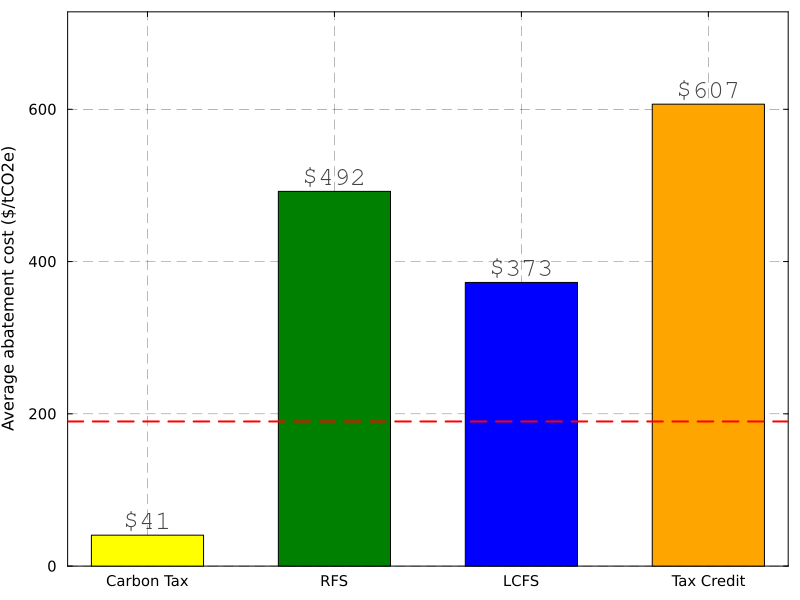

"/Users/sohyeonserenryu/Library/CloudStorage/Box-Box/second_year_paper/Julia/implicit_carbon_price.png"

In [374]:
using Plots
using Printf

# Extract implicit carbon prices for policies 2-5 (excluding Status Quo)
policy_names_short = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]
implicit_prices = results["average_abatement_cost"]["implicit_price"][2:5]

# Define colors for each bar
bar_colors = [:yellow, :green, :blue, :orange]

# Create bar plot
p = plot(size = (800, 600), framestyle = :box)

# Add each bar individually with its own color
for i in 1:4
    bar!(p, [i], [implicit_prices[i]], 
         color = bar_colors[i],
         label = "",
         bar_width = 0.6)
end

# Set plot properties
plot!(p,
    xlabel = "",
    ylabel = "Average abatement cost (\$/tCO2e)",
    legend = false,
    ylims = (0, maximum(implicit_prices) * 1.2),
    grid = true,
    gridalpha = 0.3,
    gridstyle = :dash,
    xticks = (1:4, policy_names_short),
    xrotation = 0,
    tickfontsize = 10
)

# Add horizontal reference line at 190
hline!(p, [190], linestyle=:dash, color=:red, linewidth=2, label="")

# Add value labels on top of each bar (centered and bold)
for i in 1:length(implicit_prices)
    annotate!(p, i, implicit_prices[i] + maximum(implicit_prices) * 0.03, 
              text(@sprintf("\$%d", round(Int, implicit_prices[i])), :center, 14, :black, :bold))
end

# Display the plot
display(p)

# Optional: Save the plot
savefig(p, "implicit_carbon_price.png")

Save figures and tables

Table 1. Model Validation

Implicit tax and subsidy

In [ ]:
using Plots

function save_plot_as_png(plot_obj, filename="implicit_tax_plot.png")
    savefig(plot_obj, filename)
    println("✓ Plot saved to: $filename")
end
save_plot_as_png(implicit_tax_plot, "implicit_tax_plot.png")

Table 2. SAF policy

In [ ]:
using CSV, DataFrames

clean_small(val, threshold=1e-4) = abs(val) < threshold ? 0.0 : val

function export_table2_to_csv(results, params, filename="table2_saf_policies.csv")
    Scenarios = ["Status quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    rows_data = [
        ("Jet Fuel (x1)", "variables", params[:meta][:process][1]),
        ("Conventional ATJ-SAF (x2)", "variables", params[:meta][:process][2]),
        ("Climate-Smart ATJ-SAF (x3)", "variables", params[:meta][:process][3]),
        ("Conventional HEFA-SAF (x4)", "variables", params[:meta][:process][4]),
        ("Climate-Smart HEFA-SAF (x5)", "variables", params[:meta][:process][5]),
        ("Non-soy HEFA-SAF (x6)", "variables", params[:meta][:process][6]),
        ("Total Conventional SAF (x2+x4)", "derived", "conventional_saf"),
        ("Total Climate-Smart SAF (x3+x5)", "derived", "climate_smart_saf"),
        ("Total SAF (x2+x3+x4+x5+x6)", "derived", "total_saf"),
        ("Total Aviation Fuel", "production", "aviation"),
        ("SAF share in aviation fuel (%)", "derived", "saf_share_aviation"),
        ("Climate-smart SAF in SAF (%)", "derived", "climate_smart_share_saf"),
        ("RPM (billion miles)", "production", "rpm")
    ]
    
    df = DataFrame()
    df[!, :Item] = [label for (label, _, _) in rows_data]
    
    for (idx, scenario) in enumerate(Scenarios)
        col_values = []
        for (label, category, key) in rows_data
            val = clean_small(results[category][key][idx])
            push!(col_values, val)
        end
        df[!, Symbol(scenario)] = col_values
    end
    
    CSV.write(filename, df)
    println("✓ Table 2 saved to: $filename")
    
    return df
end

df = export_table2_to_csv(results, params, "table2_saf_policies.csv")

SAF, jet fuel, VMT price figure

In [ ]:
savefig(combined_plot, "/Users/sohyeonserenryu/Library/CloudStorage/Box-Box/second_year_paper/Julia/price_plots.png")
println("✓ Saved combined plot to: /Users/sohyeonserenryu/Library/CloudStorage/Box-Box/second_year_paper/Julia/price_plots.png")

Table3. road, food table

In [ ]:
using CSV, DataFrames

clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

function export_table3_to_csv(results, params, filename="table3_road_fuel_food.csv")
    Scenarios = ["Status Quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    rows_data = [
        ("Gasoline (x7)", "variables", params[:meta][:process][7], "normal"),
        ("Ethanol (x8)", "variables", params[:meta][:process][8], "normal"),
        ("Diesel (x9)", "variables", params[:meta][:process][9], "normal"),
        ("Biodiesel (x10+x11)", "", "", "biodiesel_total"),
        ("  Soy Biodiesel (x10)", "variables", params[:meta][:process][10], "normal"),
        ("  Non-soy Biodiesel (x11)", "variables", params[:meta][:process][11], "normal"),
        ("Renewable Diesel (x12+x13)", "", "", "renewable_diesel_total"),
        ("  Soy Renewable Diesel (x12)", "variables", params[:meta][:process][12], "normal"),
        ("  Non-soy Renewable Diesel (x13)", "variables", params[:meta][:process][13], "normal"),
        ("Total Road Gasoline", "production", "road_gasoline", "normal"),
        ("Total Road Diesel", "production", "road_diesel", "normal"),
        ("VMT: Gasoline (billion miles)", "production", "vmt_gasoline", "normal"),
        ("VMT: Diesel (billion miles)", "production", "vmt_diesel", "normal"),
        ("Food: Corn (billion bushels)", "production", "food_corn", "normal"),
        ("Food: Soy oil (billion lbs)", "production", "food_soy", "normal")
    ]
    
    items = []
    scenario_cols = Dict(scenario => [] for scenario in Scenarios)
    
    for (label, category, key, special) in rows_data
        row_values = []
        for idx in 1:5
            if special == "biodiesel_total"
                bd_soy = clean_small(results["variables"][params[:meta][:process][10]][idx])
                bd_nonsoy = clean_small(results["variables"][params[:meta][:process][11]][idx])
                val = bd_soy + bd_nonsoy
            elseif special == "renewable_diesel_total"
                rd_soy = clean_small(results["variables"][params[:meta][:process][12]][idx])
                rd_nonsoy = clean_small(results["variables"][params[:meta][:process][13]][idx])
                val = rd_soy + rd_nonsoy
            else
                val = clean_small(results[category][key][idx])
            end
            push!(row_values, val)
        end
        
        push!(items, label)
        baseline = row_values[1]
        
        for (idx, scenario) in enumerate(Scenarios)
            if idx == 1
                push!(scenario_cols[scenario], row_values[idx])
            else
                current = row_values[idx]
                if baseline > 1e-10
                    pct = round(((current - baseline) / baseline) * 100, digits=3)
                    push!(scenario_cols[scenario], pct)
                else
                    push!(scenario_cols[scenario], "N/A")
                end
            end
        end
    end
    
    df = DataFrame(Item = items)
    for scenario in Scenarios
        df[!, Symbol(scenario)] = scenario_cols[scenario]
    end
    
    CSV.write(filename, df)
    println("✓ Table 3 (Road Vehicle Fuel & Food) saved to: $filename")
    
    return df
end

df = export_table3_to_csv(results, params, "table3_road_fuel_food.csv")

Table4. land

In [ ]:
using CSV, DataFrames

# 매우 작은 값 정리 함수
clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

function export_table4_to_csv(results, params, filename="table4_land_allocation.csv")
    # 시나리오 이름
    Scenarios = ["Status quo", "Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    # 테이블 데이터 정의 (레이블, 카테고리, 키, 타입)
    rows_data = [
        ("Corn: Conventional ATJ-SAF (%)", "land_derived", "corn_atj_share", "normal"),
        ("Corn: Climate-Smart ATJ-SAF (%)", "land_derived", "corn_cs_atj_share", "normal"),
        ("Corn: Ethanol (%)", "land_derived", "corn_ethanol_share", "normal"),
        ("Corn: Food (%)", "land_derived", "corn_food_share", "normal"),
        ("Corn Land Shadow Price (\$/acre)", "shadow_values", "land_corn", "shadow_price"),
        ("Soy: Conventional HEFA-SAF (%)", "land_derived", "soy_hefa_share", "normal"),
        ("Soy: Climate-Smart HEFA-SAF (%)", "land_derived", "soy_cs_hefa_share", "normal"),
        ("Soy: Biodiesel (%)", "land_derived", "soy_biodiesel_share", "normal"),
        ("Soy: Renewable Diesel (%)", "land_derived", "soy_rd_share", "normal"),
        ("Soy: Food (%)", "land_derived", "soy_food_share", "normal"),
        ("Soy Land Shadow Price (\$/acre)", "shadow_values", "land_soy", "shadow_price"),
        ("Climate-Smart Land Use Share (%)", "land_derived", "climate_smart_land_share", "normal")
    ]
    
    # DataFrame 생성
    df = DataFrame()
    df[!, :Item] = [label for (label, _, _, _) in rows_data]
    
    # 각 시나리오별 값 추가
    for (idx, scenario) in enumerate(Scenarios)
        col_values = []
        for (label, category, key, val_type) in rows_data
            if val_type == "shadow_price"
                # Shadow price는 절댓값 사용
                val = clean_small(results[category][key][idx])
                if isnan(val)
                    push!(col_values, "N/A")
                else
                    push!(col_values, round(abs(val), digits=2))
                end
            else
                # 일반 share 값
                val = clean_small(results[category][key][idx])
                push!(col_values, round(val, digits=2))
            end
        end
        df[!, Symbol(scenario)] = col_values
    end
    
    # CSV 파일로 저장
    CSV.write(filename, df)
    println("✓ Table 4 (Land Allocation) saved to: $filename")
    
    return df
end

# 사용 예시:
df = export_table4_to_csv(results, params, "table4_land_allocation.csv")

Table5. carbon emissions

In [ ]:
using CSV, DataFrames

clean_small(val, threshold=1e-10) = abs(val) < threshold ? 0.0 : val

function export_table5_to_csv(results, params, filename="table5_emission_changes.csv")
    scenarios = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    emission_rows = [
        ("Aviation", "aviation", ["aviation"]),
        ("Road vehicle", "road_total", ["road_gasoline", "road_diesel"]),
        ("  Gasoline", "road_gasoline", ["road_gasoline"]),
        ("  Diesel", "road_diesel", ["road_diesel"]),
        ("Food", "food_total", ["food_corn", "food_soy"]),
        ("  Corn", "food_corn", ["food_corn"]),
        ("  Soy", "food_soy", ["food_soy"]),
        ("Total changes", "total", ["total"])
    ]
    
    df = DataFrame()
    df[!, :Category] = [label for (label, _, _) in emission_rows]
    
    for (idx, scenario) in enumerate(scenarios)
        policy = idx + 1  # policy 2~5
        col_values = []
        
        for (label, category, keys) in emission_rows
            sq_value = sum(results["emissions"][key][1] for key in keys)
            
            current_value = sum(results["emissions"][key][policy] for key in keys)
            
            change = clean_small((current_value - sq_value) * 1000)
            push!(col_values, round(change, digits=2))
        end
        
        df[!, Symbol(scenario)] = col_values
    end
    
    CSV.write(filename, df)
    println("✓ Table 5 (Emission Changes) saved to: $filename")
    
    return df
end

df = export_table5_to_csv(results, params, "table5_emission_changes.csv")

Table 6. welfare

In [ ]:
using CSV, DataFrames

function export_welfare_table_to_csv(results, scc=190, filename="table6_welfare_analysis.csv")
    scenarios = ["Carbon Tax", "RFS", "LCFS", "Tax Credit"]
    
    welfare_rows = [
        ("Aviation Sector", "Consumer (a1)", (policy) -> results["welfare"]["cs_aviation"][policy] * 1000),
        ("Aviation Sector", "Producer (b1)", (policy) -> results["welfare"]["ps_aviation"][policy] * 1000),
        ("Aviation Sector", "Government revenue (c)", (policy) -> policy in [3, 4] ? missing : results["welfare"]["government_revenue_aviation"][policy] * 1000),
        ("Aviation Sector", "Economic surplus (Δ1 = a1 + b1 + c)", (policy) -> results["welfare"]["sw_aviation"][policy] * 1000),
        ("Aviation Sector", "Dead weight loss", (policy) -> begin
            val = results["welfare"]["DWL_aviation"][policy]
            isnan(val) ? missing : val * 1000
        end),
        
        ("Road Vehicle Sector", "Consumer (a2)", (policy) -> (results["welfare"]["cs_road_gasoline"][policy] + results["welfare"]["cs_road_diesel"][policy]) * 1000),
        ("Road Vehicle Sector", "Producer (b2)", (policy) -> (results["welfare"]["ps_road_gasoline"][policy] + results["welfare"]["ps_road_diesel"][policy]) * 1000),
        ("Road Vehicle Sector", "Economic surplus (Δ2 = a2 + b2)", (policy) -> (results["welfare"]["sw_road_gasoline"][policy] + results["welfare"]["sw_road_diesel"][policy]) * 1000),
        
        ("Food Sector", "Consumer (a3)", (policy) -> (results["welfare"]["cs_food_corn"][policy] + results["welfare"]["cs_food_soy"][policy]) * 1000),
        ("Food Sector", "Producer (b3)", (policy) -> (results["welfare"]["ps_food_corn"][policy] + results["welfare"]["ps_food_soy"][policy]) * 1000),
        ("Food Sector", "Economic surplus (Δ3 = a3 + b3)", (policy) -> (results["welfare"]["sw_food_corn"][policy] + results["welfare"]["sw_food_soy"][policy]) * 1000),
        
        ("All Sectors", "Economic surplus (Δ = Δ1 + Δ2 + Δ3)", (policy) -> results["welfare"]["sw_total"][policy] * 1000),
        ("All Sectors", "Reduction in externality costs (d)", (policy) -> begin
            emission_reduction = (results["emissions"]["total"][1] - results["emissions"]["total"][policy]) * 1000
            emission_reduction * scc
        end),
        ("All Sectors", "Social welfare (Δ + d)", (policy) -> begin
            total_delta = results["welfare"]["sw_total"][policy] * 1000
            emission_reduction = (results["emissions"]["total"][1] - results["emissions"]["total"][policy]) * 1000
            externality_reduction = emission_reduction * scc
            total_delta + externality_reduction
        end)
    ]
    
    df = DataFrame()
    df[!, :Section] = [section for (section, _, _) in welfare_rows]
    df[!, :Item] = [label for (_, label, _) in welfare_rows]
    
    for (idx, scenario) in enumerate(scenarios)
        policy = idx + 1  # policy 2~5
        col_values = []
        
        for (section, label, calc_func) in welfare_rows
            val = calc_func(policy)
            if ismissing(val)
                push!(col_values, missing)
            else
                push!(col_values, round(val, digits=2))
            end
        end
        
        df[!, Symbol(scenario)] = col_values
    end
    
    CSV.write(filename, df)
    println("✓ Welfare Table saved to: $filename")
    println("  (SCC used: \$$(scc)/ton CO2e)")
    
    return df
end

 scc = 190  # Social Cost of Carbon ($/ton CO2e)
 df = export_welfare_table_to_csv(results, scc, "table6_welfare_analysis.csv")

In [375]:
# Helper function to extract aviation fuel values
function extract_aviation_values(model)
    x = all_variables(model)
    vals = value.(x)
    return vals[1:6]  # x1 to x6 (absolute production quantities)
end

# 1. CARBON TAX SENSITIVITY
println("\n" * "="^70)
println("1. CARBON TAX SENSITIVITY (0 to 250 \$/ton CO2)")
println("="^70)

t_values = range(0, 190, length=190)
carbontax_results = []

for (i, t) in enumerate(t_values)
    print("\rProgress: $(i)/$(length(t_values))")
    model = model_carbontax(params, L_corn_used, L_soy_used; t=t)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        vals = extract_aviation_values(model)
        push!(carbontax_results, vals)
    else
        push!(carbontax_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 2. RFS SENSITIVITY
println("\n" * "="^70)
println("2. RFS MANDATE SENSITIVITY (0 to 0.3 blending ratio)")
println("="^70)

theta_values = range(0, 0.128489, length=190)
rfs_results = []

for (i, theta_avi) in enumerate(theta_values)
    print("\rProgress: $(i)/$(length(theta_values))")
    model = model_rfs(params, L_corn_used, L_soy_used; theta_avi=theta_avi)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        vals = extract_aviation_values(model)
        push!(rfs_results, vals)
    else
        push!(rfs_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 3. LCFS SENSITIVITY (reversed - from 1.0 to 0.93)
println("\n" * "="^70)
println("3. LCFS SENSITIVITY (1.0 to 0.93 CI limit)")
println("="^70)

sigma_values = reverse(range(0.951034, 1.0, length=190))  # Reversed: 1.0 -> 0.93
lcfs_results = []

for (i, sigma) in enumerate(sigma_values)
    print("\rProgress: $(i)/$(length(sigma_values))")
    model = model_lcfs(params, L_corn_used, L_soy_used; sigma=sigma)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        vals = extract_aviation_values(model)
        push!(lcfs_results, vals)
    else
        push!(lcfs_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 4. TAX CREDIT SENSITIVITY
println("\n" * "="^70)
println("4. TAX CREDIT SENSITIVITY (0 to 35 \$/ton CO2 avoided)")
println("="^70)

p_values = range(0, 28.1428, length=190)
credit_results = []

for (i, p) in enumerate(p_values)
    print("\rProgress: $(i)/$(length(p_values))")
    model = model_credit(params, L_corn_used, L_soy_used; p=p)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        vals = extract_aviation_values(model)
        push!(credit_results, vals)
    else
        push!(credit_results, fill(NaN, 6))
    end
end
println("\nCompleted!")



1. CARBON TAX SENSITIVITY (0 to 250 $/ton CO2)
Progress: 190/190
Completed!

2. RFS MANDATE SENSITIVITY (0 to 0.3 blending ratio)
Progress: 190/190
Completed!

3. LCFS SENSITIVITY (1.0 to 0.93 CI limit)
Progress: 190/190
Completed!

4. TAX CREDIT SENSITIVITY (0 to 35 $/ton CO2 avoided)
Progress: 190/190
Completed!


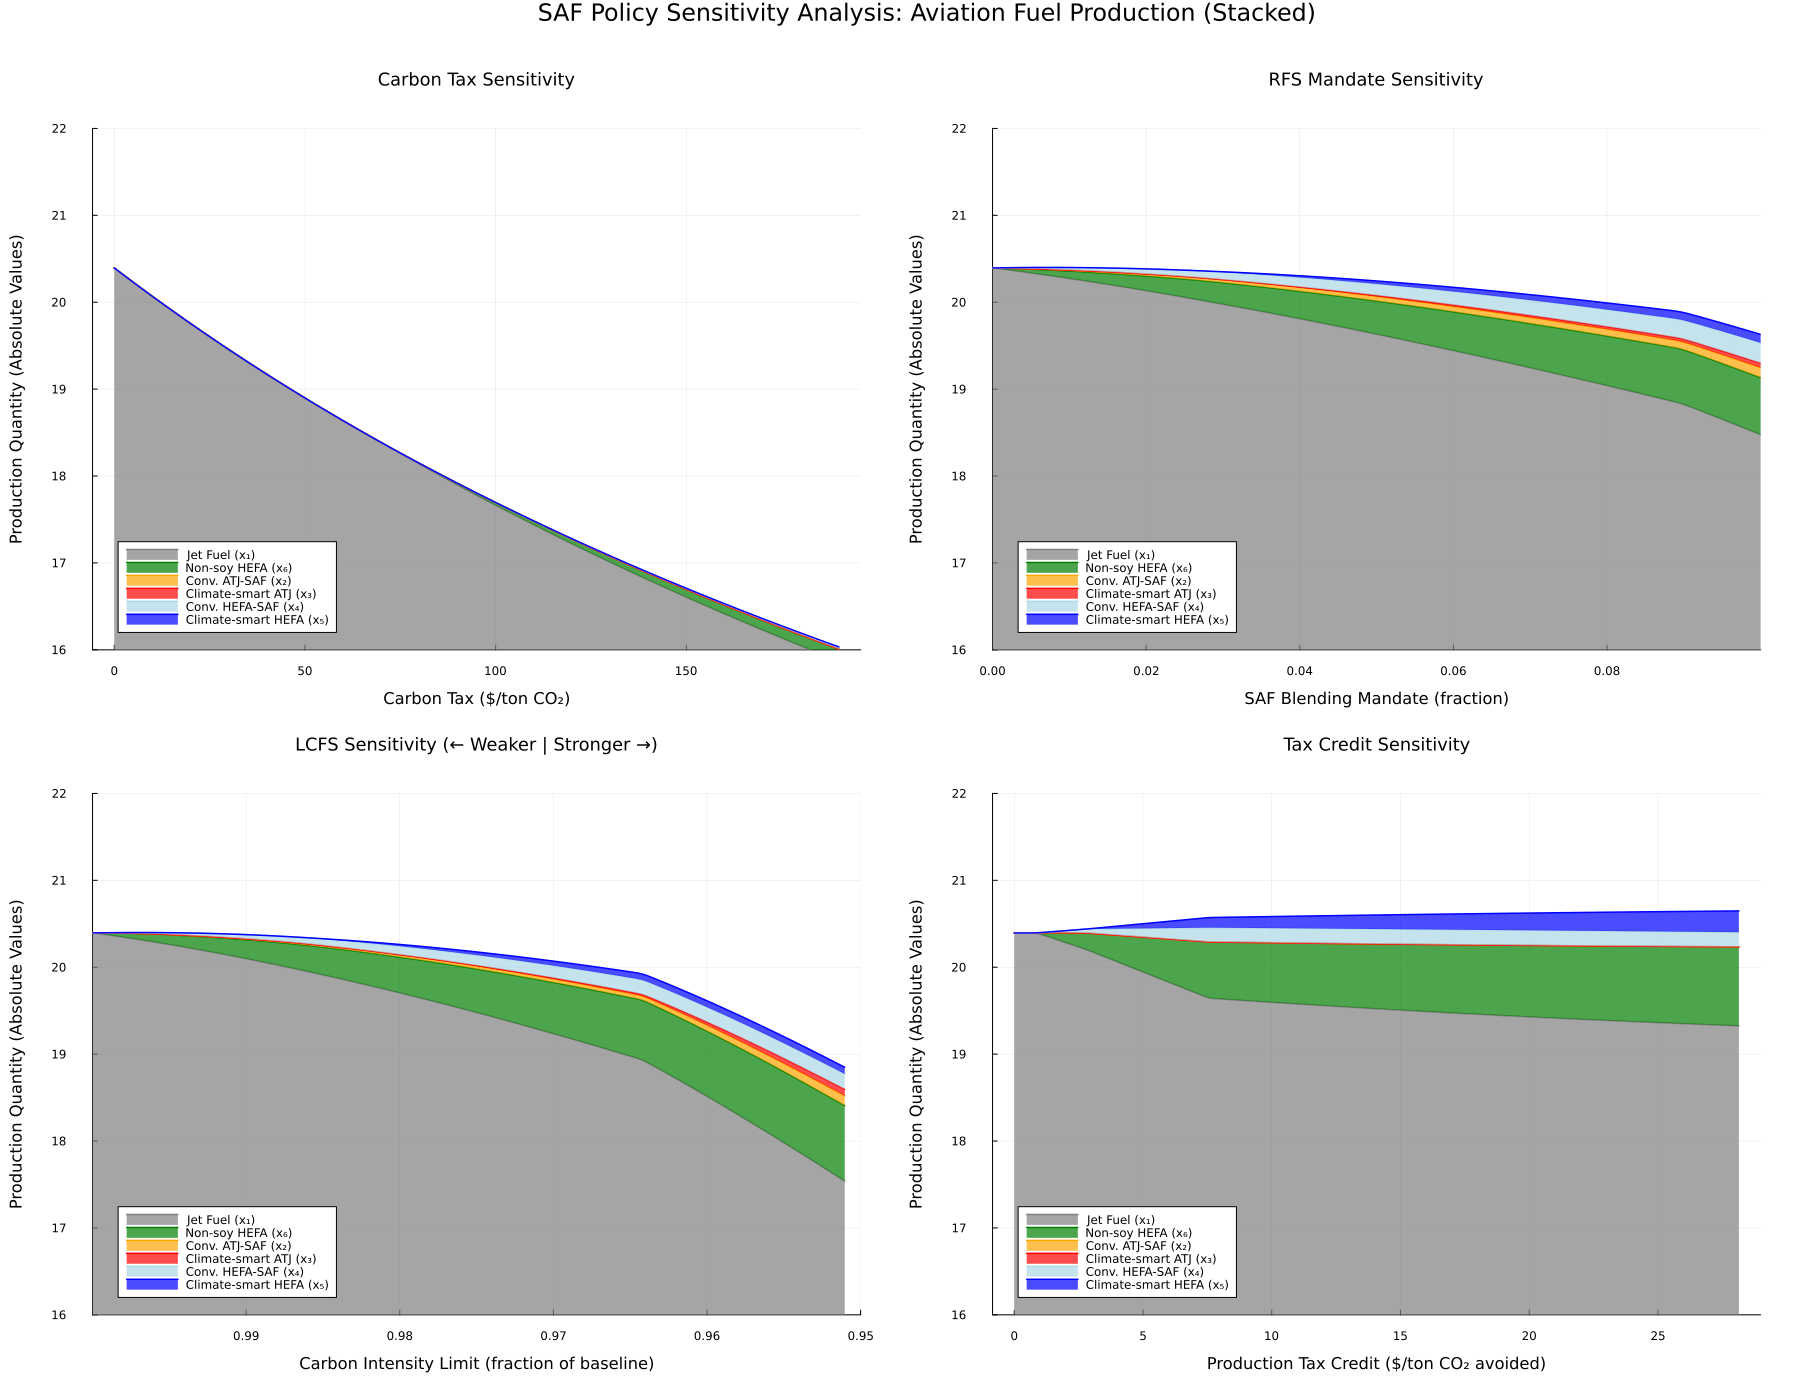


CREATING VISUALIZATIONS


In [376]:
# Create plots with absolute values (STACKED AREA CHART)
println("\n" * "="^70)
println("CREATING VISUALIZATIONS")
println("="^70)

# Plot styling - REORDERED: x1 (bottom), x6, then x2-x5
# Order: Jet Fuel, Non-soy HEFA, Conv ATJ, Climate ATJ, Conv HEFA, Climate HEFA
fuel_names_display = ["Jet Fuel (x₁)", 
                      "Non-soy HEFA (x₆)",
                      "Conv. ATJ-SAF (x₂)", 
                      "Climate-smart ATJ (x₃)", 
                      "Conv. HEFA-SAF (x₄)", 
                      "Climate-smart HEFA (x₅)"]
fuel_colors_display = [:gray, :green, :orange , :red, :lightblue, :blue]

# Convert results to matrices and REORDER columns: [x1, x6, x2, x3, x4, x5]
carbontax_matrix_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in carbontax_results]...)'
rfs_matrix_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in rfs_results]...)'
lcfs_matrix_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in lcfs_results]...)'
credit_matrix_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in credit_results]...)'

# 1. Carbon Tax Plot - STACKED AREA
p1 = plot(title="Carbon Tax Sensitivity", 
          xlabel="Carbon Tax (\$/ton CO₂)", 
          ylabel="Production Quantity (Absolute Values)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(16, 22))

areaplot!(p1, collect(t_values), carbontax_matrix_reordered,
          labels=permutedims(fuel_names_display),
          fillalpha=0.7,
          linewidth=1.5,
          color=permutedims(fuel_colors_display))

# 2. RFS Plot - STACKED AREA
p2 = plot(title="RFS Mandate Sensitivity", 
          xlabel="SAF Blending Mandate (fraction)", 
          ylabel="Production Quantity (Absolute Values)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(16, 22),
          xlims=(0, 0.1))

areaplot!(p2, collect(theta_values), rfs_matrix_reordered,
          labels=permutedims(fuel_names_display),
          fillalpha=0.7,
          linewidth=1.5,
          color=permutedims(fuel_colors_display))

# 3. LCFS Plot - STACKED AREA (x-axis: 1.0 on left → 0.93 on right)
p3 = plot(title="LCFS Sensitivity (← Weaker | Stronger →)", 
          xlabel="Carbon Intensity Limit (fraction of baseline)", 
          ylabel="Production Quantity (Absolute Values)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          xflip=true,
          ylims=(16, 22),
          xlims=(0.95,1.0))

areaplot!(p3, collect(sigma_values), lcfs_matrix_reordered,
          labels=permutedims(fuel_names_display),
          fillalpha=0.7,
          linewidth=1.5,
          color=permutedims(fuel_colors_display))

# 4. Tax Credit Plot - STACKED AREA
p4 = plot(title="Tax Credit Sensitivity", 
          xlabel="Production Tax Credit (\$/ton CO₂ avoided)", 
          ylabel="Production Quantity (Absolute Values)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(16, 22))

areaplot!(p4, collect(p_values), credit_matrix_reordered,
          labels=permutedims(fuel_names_display),
          fillalpha=0.7,
          linewidth=1.5,
          color=permutedims(fuel_colors_display))

# Combined plot
p_combined = plot(p1, p2, p3, p4, 
                  layout=(2,2), 
                  size=(1800, 1400),
                  margin=8Plots.mm,
                  plot_title="SAF Policy Sensitivity Analysis: Aviation Fuel Production (Stacked)",
                  plot_titlefontsize=16)
display(p_combined)


1. CARBON TAX SENSITIVITY (0 to 250 $/ton CO2)
Progress: 1/100
t=0.0: shares = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0], sum = 100.0%
Progress: 100/100
t=33.0: shares = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0], sum = 100.0%

Completed!

2. RFS MANDATE SENSITIVITY (0 to 0.3 blending ratio)
Progress: 1/100
theta=0.0: shares = [100.0, 0.0, 0.0, 0.0, 0.0, 0.0], sum = 100.0%
Progress: 100/100
theta=0.07: shares = [95.81, 0.34, 0.12, 0.87, 0.31, 2.54], sum = 100.0%

Completed!

3. LCFS SENSITIVITY (1.0 to 0.93 CI limit)
Progress: 100/100
Completed!

4. TAX CREDIT SENSITIVITY (0 to 35 $/ton CO2 avoided)
Progress: 100/100
Completed!

CREATING VISUALIZATIONS (SHARE %)


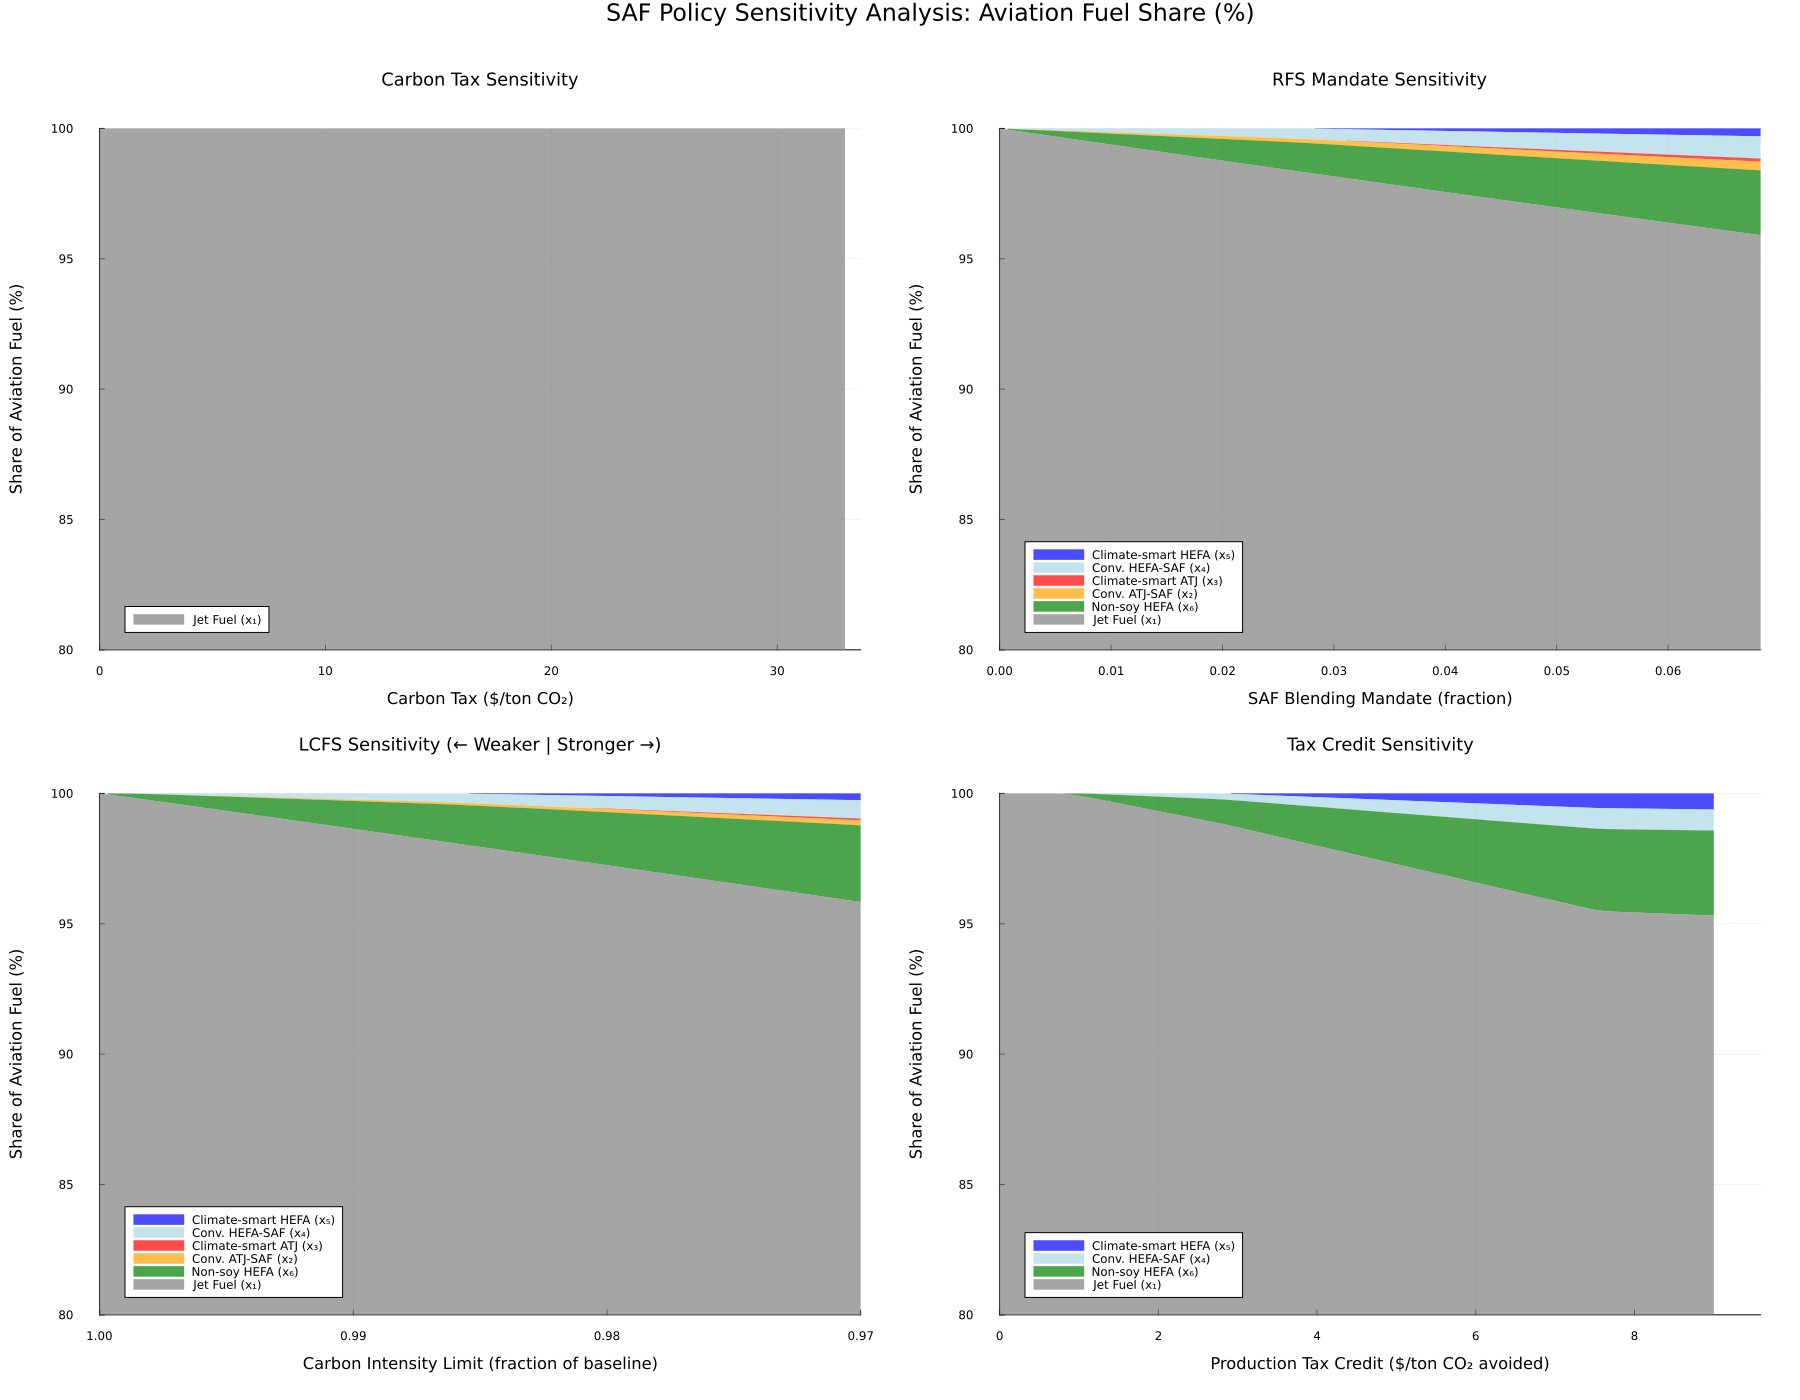

In [380]:

# Helper function to extract aviation fuel shares
function extract_aviation_shares(model)
    x = all_variables(model)
    vals = value.(x)
    
    aviation_fuels = vals[1:6]
    total = sum(aviation_fuels)
    
    if total < 1e-6
        return zeros(6)
    end
    
    return (aviation_fuels ./ total) .* 100  # Convert to percentage
end

# 1. CARBON TAX SENSITIVITY
println("\n" * "="^70)
println("1. CARBON TAX SENSITIVITY (0 to 250 \$/ton CO2)")
println("="^70)

t_values = range(0, 33, length=100)
carbontax_results = []

for (i, t) in enumerate(t_values)
    print("\rProgress: $(i)/$(length(t_values))")
    model = model_carbontax(params, L_corn_used, L_soy_used; t=t)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        shares = extract_aviation_shares(model)
        push!(carbontax_results, shares)
        
        # Debug: print first and last
        if i == 1 || i == length(t_values)
            println("\nt=$(t): shares = $(round.(shares, digits=2)), sum = $(round(sum(shares), digits=2))%")
        end
    else
        push!(carbontax_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 2. RFS SENSITIVITY
println("\n" * "="^70)
println("2. RFS MANDATE SENSITIVITY (0 to 0.3 blending ratio)")
println("="^70)

theta_values = range(0, 0.07, length=100)
rfs_results = []

for (i, theta_avi) in enumerate(theta_values)
    print("\rProgress: $(i)/$(length(theta_values))")
    model = model_rfs(params, L_corn_used, L_soy_used; theta_avi=theta_avi)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        shares = extract_aviation_shares(model)
        push!(rfs_results, shares)
        
        # Debug: print first and last
        if i == 1 || i == length(theta_values)
            println("\ntheta=$(theta_avi): shares = $(round.(shares, digits=2)), sum = $(round(sum(shares), digits=2))%")
        end
    else
        push!(rfs_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 3. LCFS SENSITIVITY (reversed - from 1.0 to 0.93)
println("\n" * "="^70)
println("3. LCFS SENSITIVITY (1.0 to 0.93 CI limit)")
println("="^70)

sigma_values = reverse(range(0.97, 1.0, length=100))
lcfs_results = []

for (i, sigma) in enumerate(sigma_values)
    print("\rProgress: $(i)/$(length(sigma_values))")
    model = model_lcfs(params, L_corn_used, L_soy_used; sigma=sigma)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        shares = extract_aviation_shares(model)
        push!(lcfs_results, shares)
    else
        push!(lcfs_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# 4. TAX CREDIT SENSITIVITY
println("\n" * "="^70)
println("4. TAX CREDIT SENSITIVITY (0 to 35 \$/ton CO2 avoided)")
println("="^70)

p_values = range(0, 9, length=100)
credit_results = []

for (i, p) in enumerate(p_values)
    print("\rProgress: $(i)/$(length(p_values))")
    model = model_credit(params, L_corn_used, L_soy_used; p=p)
    optimize!(model)
    
    if termination_status(model) == MOI.LOCALLY_SOLVED || termination_status(model) == MOI.OPTIMAL
        shares = extract_aviation_shares(model)
        push!(credit_results, shares)
    else
        push!(credit_results, fill(NaN, 6))
    end
end
println("\nCompleted!")

# Create plots with SHARE PERCENTAGES
println("\n" * "="^70)
println("CREATING VISUALIZATIONS (SHARE %)")
println("="^70)

# Plot styling - REORDERED: x1 (bottom), x6, then x2-x5
fuel_names_display = ["Jet Fuel (x₁)", 
                      "Non-soy HEFA (x₆)",
                      "Conv. ATJ-SAF (x₂)", 
                      "Climate-smart ATJ (x₃)", 
                      "Conv. HEFA-SAF (x₄)", 
                      "Climate-smart HEFA (x₅)"]
fuel_colors_display = [:gray, :green, :orange, :red, :lightblue, :blue]

# Results are ALREADY in share % from extract_aviation_shares function
# Just need to reorder: [x1, x6, x2, x3, x4, x5]
carbontax_share_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in carbontax_results]...)'
rfs_share_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in rfs_results]...)'
lcfs_share_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in lcfs_results]...)'
credit_share_reordered = hcat([r[[1, 6, 2, 3, 4, 5]] for r in credit_results]...)'

# Helper function to find indices where share is non-zero
function find_nonzero_range(vec, threshold=0.01)  # 0.01% threshold
    nonzero_idx = findall(x -> abs(x) > threshold, vec)
    if isempty(nonzero_idx)
        return 1:0
    end
    return minimum(nonzero_idx):maximum(nonzero_idx)
end

# 1. Carbon Tax Plot
p1 = plot(title="Carbon Tax Sensitivity", 
          xlabel="Carbon Tax (\$/ton CO₂)", 
          ylabel="Share of Aviation Fuel (%)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(80, 100),
          xlims=(0, 33.6931))

cum1 = carbontax_share_reordered[:, 1]
cum2 = cum1 .+ carbontax_share_reordered[:, 2]
cum3 = cum2 .+ carbontax_share_reordered[:, 3]
cum4 = cum3 .+ carbontax_share_reordered[:, 4]
cum5 = cum4 .+ carbontax_share_reordered[:, 5]
cum6 = cum5 .+ carbontax_share_reordered[:, 6]

idx6 = find_nonzero_range(carbontax_share_reordered[:, 6])
!isempty(idx6) && plot!(p1, collect(t_values)[idx6], cum6[idx6], fillrange=cum5[idx6], fillalpha=0.7, color=fuel_colors_display[6], label=fuel_names_display[6], linewidth=0)
idx5 = find_nonzero_range(carbontax_share_reordered[:, 5])
!isempty(idx5) && plot!(p1, collect(t_values)[idx5], cum5[idx5], fillrange=cum4[idx5], fillalpha=0.7, color=fuel_colors_display[5], label=fuel_names_display[5], linewidth=0)
idx4 = find_nonzero_range(carbontax_share_reordered[:, 4])
!isempty(idx4) && plot!(p1, collect(t_values)[idx4], cum4[idx4], fillrange=cum3[idx4], fillalpha=0.7, color=fuel_colors_display[4], label=fuel_names_display[4], linewidth=0)
idx3 = find_nonzero_range(carbontax_share_reordered[:, 3])
!isempty(idx3) && plot!(p1, collect(t_values)[idx3], cum3[idx3], fillrange=cum2[idx3], fillalpha=0.7, color=fuel_colors_display[3], label=fuel_names_display[3], linewidth=0)
idx2 = find_nonzero_range(carbontax_share_reordered[:, 2])
!isempty(idx2) && plot!(p1, collect(t_values)[idx2], cum2[idx2], fillrange=cum1[idx2], fillalpha=0.7, color=fuel_colors_display[2], label=fuel_names_display[2], linewidth=0)
plot!(p1, collect(t_values), cum1, fillrange=0, fillalpha=0.7, color=fuel_colors_display[1], label=fuel_names_display[1], linewidth=0)

# 2. RFS Plot
p2 = plot(title="RFS Mandate Sensitivity", 
          xlabel="SAF Blending Mandate (fraction)", 
          ylabel="Share of Aviation Fuel (%)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(80, 100),
          xlims=(0, 0.068301))

cum1 = rfs_share_reordered[:, 1]
cum2 = cum1 .+ rfs_share_reordered[:, 2]
cum3 = cum2 .+ rfs_share_reordered[:, 3]
cum4 = cum3 .+ rfs_share_reordered[:, 4]
cum5 = cum4 .+ rfs_share_reordered[:, 5]
cum6 = cum5 .+ rfs_share_reordered[:, 6]

idx6 = find_nonzero_range(rfs_share_reordered[:, 6])
!isempty(idx6) && plot!(p2, collect(theta_values)[idx6], cum6[idx6], fillrange=cum5[idx6], fillalpha=0.7, color=fuel_colors_display[6], label=fuel_names_display[6], linewidth=0)
idx5 = find_nonzero_range(rfs_share_reordered[:, 5])
!isempty(idx5) && plot!(p2, collect(theta_values)[idx5], cum5[idx5], fillrange=cum4[idx5], fillalpha=0.7, color=fuel_colors_display[5], label=fuel_names_display[5], linewidth=0)
idx4 = find_nonzero_range(rfs_share_reordered[:, 4])
!isempty(idx4) && plot!(p2, collect(theta_values)[idx4], cum4[idx4], fillrange=cum3[idx4], fillalpha=0.7, color=fuel_colors_display[4], label=fuel_names_display[4], linewidth=0)
idx3 = find_nonzero_range(rfs_share_reordered[:, 3])
!isempty(idx3) && plot!(p2, collect(theta_values)[idx3], cum3[idx3], fillrange=cum2[idx3], fillalpha=0.7, color=fuel_colors_display[3], label=fuel_names_display[3], linewidth=0)
idx2 = find_nonzero_range(rfs_share_reordered[:, 2])
!isempty(idx2) && plot!(p2, collect(theta_values)[idx2], cum2[idx2], fillrange=cum1[idx2], fillalpha=0.7, color=fuel_colors_display[2], label=fuel_names_display[2], linewidth=0)
plot!(p2, collect(theta_values), cum1, fillrange=0, fillalpha=0.7, color=fuel_colors_display[1], label=fuel_names_display[1], linewidth=0)

# 3. LCFS Plot
p3 = plot(title="LCFS Sensitivity (← Weaker | Stronger →)", 
          xlabel="Carbon Intensity Limit (fraction of baseline)", 
          ylabel="Share of Aviation Fuel (%)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          xflip=true,
          ylims=(80, 100),
          xlims=(0.97,1.0))

cum1 = lcfs_share_reordered[:, 1]
cum2 = cum1 .+ lcfs_share_reordered[:, 2]
cum3 = cum2 .+ lcfs_share_reordered[:, 3]
cum4 = cum3 .+ lcfs_share_reordered[:, 4]
cum5 = cum4 .+ lcfs_share_reordered[:, 5]
cum6 = cum5 .+ lcfs_share_reordered[:, 6]

idx6 = find_nonzero_range(lcfs_share_reordered[:, 6])
!isempty(idx6) && plot!(p3, collect(sigma_values)[idx6], cum6[idx6], fillrange=cum5[idx6], fillalpha=0.7, color=fuel_colors_display[6], label=fuel_names_display[6], linewidth=0)
idx5 = find_nonzero_range(lcfs_share_reordered[:, 5])
!isempty(idx5) && plot!(p3, collect(sigma_values)[idx5], cum5[idx5], fillrange=cum4[idx5], fillalpha=0.7, color=fuel_colors_display[5], label=fuel_names_display[5], linewidth=0)
idx4 = find_nonzero_range(lcfs_share_reordered[:, 4])
!isempty(idx4) && plot!(p3, collect(sigma_values)[idx4], cum4[idx4], fillrange=cum3[idx4], fillalpha=0.7, color=fuel_colors_display[4], label=fuel_names_display[4], linewidth=0)
idx3 = find_nonzero_range(lcfs_share_reordered[:, 3])
!isempty(idx3) && plot!(p3, collect(sigma_values)[idx3], cum3[idx3], fillrange=cum2[idx3], fillalpha=0.7, color=fuel_colors_display[3], label=fuel_names_display[3], linewidth=0)
idx2 = find_nonzero_range(lcfs_share_reordered[:, 2])
!isempty(idx2) && plot!(p3, collect(sigma_values)[idx2], cum2[idx2], fillrange=cum1[idx2], fillalpha=0.7, color=fuel_colors_display[2], label=fuel_names_display[2], linewidth=0)
plot!(p3, collect(sigma_values), cum1, fillrange=0, fillalpha=0.7, color=fuel_colors_display[1], label=fuel_names_display[1], linewidth=0)

# 4. Tax Credit Plot
p4 = plot(title="Tax Credit Sensitivity", 
          xlabel="Production Tax Credit (\$/ton CO₂ avoided)", 
          ylabel="Share of Aviation Fuel (%)",
          legend=:bottomleft, 
          size=(900, 600),
          legendfontsize=8,
          guidefontsize=11,
          titlefontsize=12,
          ylims=(80, 100),
          xlims=(0, 9.59))

cum1 = credit_share_reordered[:, 1]
cum2 = cum1 .+ credit_share_reordered[:, 2]
cum3 = cum2 .+ credit_share_reordered[:, 3]
cum4 = cum3 .+ credit_share_reordered[:, 4]
cum5 = cum4 .+ credit_share_reordered[:, 5]
cum6 = cum5 .+ credit_share_reordered[:, 6]

idx6 = find_nonzero_range(credit_share_reordered[:, 6])
!isempty(idx6) && plot!(p4, collect(p_values)[idx6], cum6[idx6], fillrange=cum5[idx6], fillalpha=0.7, color=fuel_colors_display[6], label=fuel_names_display[6], linewidth=0)
idx5 = find_nonzero_range(credit_share_reordered[:, 5])
!isempty(idx5) && plot!(p4, collect(p_values)[idx5], cum5[idx5], fillrange=cum4[idx5], fillalpha=0.7, color=fuel_colors_display[5], label=fuel_names_display[5], linewidth=0)
idx4 = find_nonzero_range(credit_share_reordered[:, 4])
!isempty(idx4) && plot!(p4, collect(p_values)[idx4], cum4[idx4], fillrange=cum3[idx4], fillalpha=0.7, color=fuel_colors_display[4], label=fuel_names_display[4], linewidth=0)
idx3 = find_nonzero_range(credit_share_reordered[:, 3])
!isempty(idx3) && plot!(p4, collect(p_values)[idx3], cum3[idx3], fillrange=cum2[idx3], fillalpha=0.7, color=fuel_colors_display[3], label=fuel_names_display[3], linewidth=0)
idx2 = find_nonzero_range(credit_share_reordered[:, 2])
!isempty(idx2) && plot!(p4, collect(p_values)[idx2], cum2[idx2], fillrange=cum1[idx2], fillalpha=0.7, color=fuel_colors_display[2], label=fuel_names_display[2], linewidth=0)
plot!(p4, collect(p_values), cum1, fillrange=0, fillalpha=0.7, color=fuel_colors_display[1], label=fuel_names_display[1], linewidth=0)

# Combined plot
p_combined = plot(p1, p2, p3, p4, 
                  layout=(2,2), 
                  size=(1800, 1400),
                  margin=8Plots.mm,
                  plot_title="SAF Policy Sensitivity Analysis: Aviation Fuel Share (%)",
                  plot_titlefontsize=16)